In [ ]:
import numpy as np
from scipy import linalg
import sys
sys.path.append('Models')
from utils import find_nearest
from molecules import diatomic_molecule_Hamiltonian
from qbksp import create_T_S_block_numerical
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import pickle as pkl
from qiskit_algorithms import NumPyEigensolver
from qiskit_nature.second_q.algorithms import ExcitedStatesEigensolver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit.quantum_info import Statevector
from matplotlib.colorbar import ColorbarBase
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
# --- Helper Functions ---
def load_pickle(path):
    with open(path, 'rb') as f:
        return pkl.load(f)
    
Data_path = 'ADD YOUR PATH HERE'

# LiH - plots and analysis

In [19]:
# Problem Setup
problem_reduced, qubit_op, matrix_op, coefs, paulis, hf_state = diatomic_molecule_Hamiltonian(['Li', 'H'], 1.6)
mapper = ParityMapper(problem_reduced.num_particles)

In [20]:
# Classical energy calculation
algo = NumPyEigensolver(k=276)
algo.filter_criterion = problem_reduced.get_default_filter_criterion()
solver = ExcitedStatesEigensolver(mapper, algo)
result = solver.solve(problem_reduced)

print(f"Total ground state energy = {result.total_energies[0]:.4f}")
print(f"Total first excited state energy = {result.total_energies[1]:.3f}")
print(f"Total second excited state energy = {result.total_energies[2]:.3f}")

Total ground state energy = -7.8821
Total first excited state energy = -7.749
Total second excited state energy = -7.697


In [21]:
# Retrieve the dipole moment property
dipole_property = problem_reduced.properties.electronic_dipole_moment


dipole_operators = dipole_property.second_q_ops()
dip_x = dipole_operators['XDipole']
dip_y = dipole_operators['YDipole']
dip_z = dipole_operators['ZDipole']

mapper = ParityMapper(problem_reduced.num_particles)

# Create the excited states
qubit_op_dipole = mapper.map(dip_x)
qubit_op_dipole = qubit_op_dipole.to_matrix()
excited_state = qubit_op_dipole@Statevector(hf_state).data
qubit_op_y = mapper.map(dip_y)
qubit_op_y = qubit_op_y.to_matrix()

excited_state_y = qubit_op_y@Statevector(hf_state).data
qubit_op_z = mapper.map(dip_z)
qubit_op_z = qubit_op_z.to_matrix()
excited_state_z = qubit_op_z@Statevector(hf_state).data

### Initial state

/tmp/ipykernel_1719/932279063.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


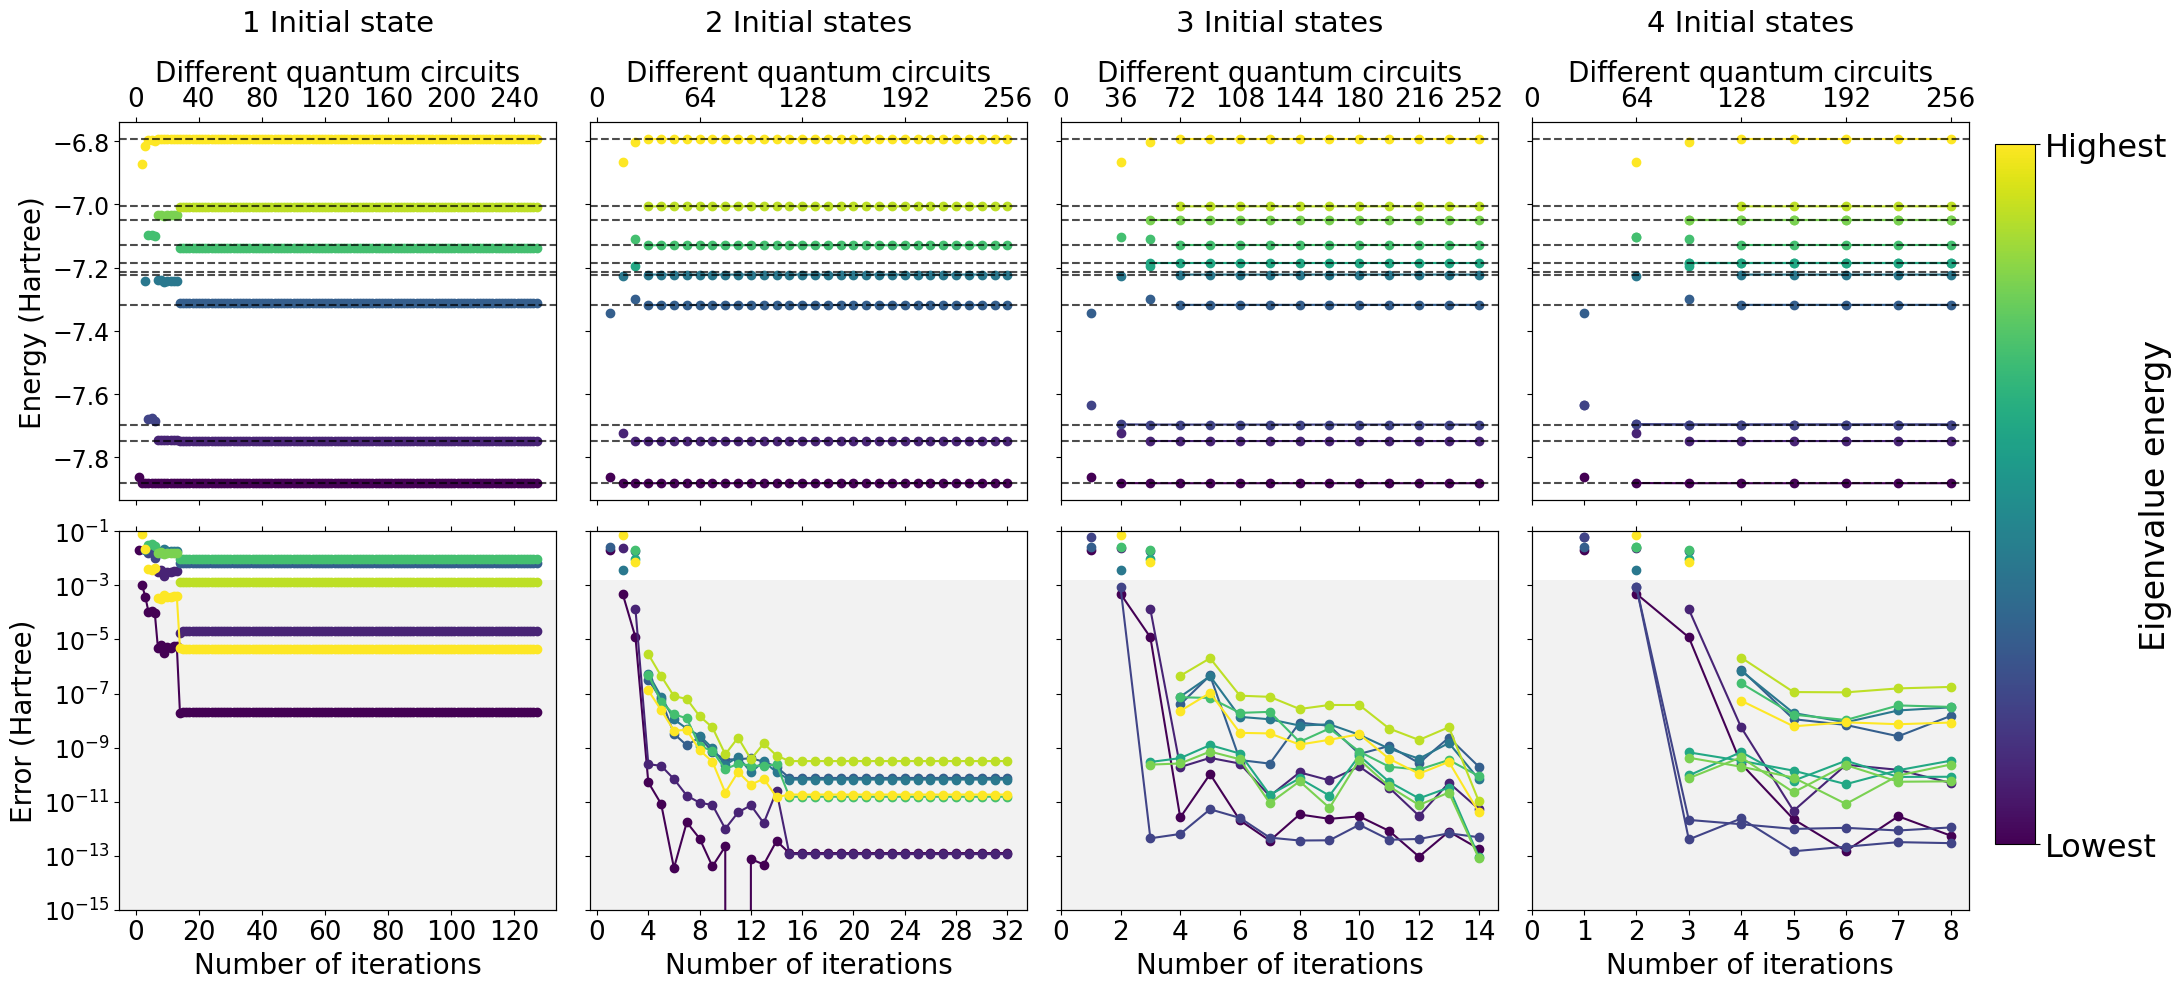

In [44]:

# --- Configuration ---
Nstates = 11
num_tracks_per_state = 5
size = 256
colors = plt.colormaps['viridis'](np.linspace(0, 1, Nstates))
norm = Normalize(vmin=0, vmax=10)
cmap = plt.colormaps['viridis']

# --- Matrix Initialization and Normalization ---
randm = matrix_op
norm_val = np.linalg.norm(randm, 2)
rand = randm / norm_val
exp = linalg.expm(-1j * rand * 3)
eigvals = np.unique(np.round(result.eigenvalues, 12))


# Define initial state collections
state = np.array([Statevector(hf_state).data])
state2 = np.array([Statevector(hf_state).data,excited_state_z])
state3 = np.array([Statevector(hf_state).data,excited_state,excited_state_y,excited_state_z])
state4 = np.array([excited_state,Statevector(hf_state).data,excited_state_z])
states_list = [state, state2, state4, state3]

# --- Plotting Setup ---
plt.figure(figsize=(20, 10))
index_p = 1

# --- Processing Each Initial State Set ---
for states in states_list:
    Ninitial = len(states)
    T, S = create_T_S_block_numerical(states, exp, 15)

    ite = np.arange(0, 15, 2)
    ite2 = np.arange(0, 15, 2)
    K=15
    if Ninitial == 1:
        ite = np.arange(0, 128, 20)
        ite2 = np.arange(0, 128, 20)
        K = 128
    if Ninitial == 2:
        ite = np.arange(0, 33, 4)
        ite2 = np.arange(0, 33, 8)
        K = 33 
    if Ninitial == 4:
        ite = np.arange(0, 9, 1)
        ite2 = np.arange(0, 9, 2)
        K = 9

    list_eigs = [[] for _ in range(num_tracks_per_state * Nstates)]
    list_iter = [[] for _ in range(num_tracks_per_state * Nstates)]

    for i in range(1, K):
        dim = Ninitial * i
        Ttemp = T[:dim, :dim]
        Stemp = S[:dim, :dim]

        s, V, d = np.linalg.svd(Stemp)
        s, d = np.conj(s).T, np.conj(d).T
        Ttemp = d @ Ttemp @ s
        Stemp = d @ Stemp @ s
        idxs = np.where(V > 1e-10)[0]
        Ttemp, Stemp = Ttemp[np.ix_(idxs, idxs)], Stemp[np.ix_(idxs, idxs)]

        eigsv = linalg.eig(Ttemp, Stemp)[0]
        eigsv_angle = -np.angle(eigsv)
        eigsv_angle = eigsv_angle[np.abs(eigsv_angle) < 3.000001] * norm_val / 3
        

        assigned_sublists = [set() for _ in range(Nstates)]

        for elem in eigsv_angle:
            near, idx = find_nearest(eigvals, elem)
            if idx >= Nstates:
                continue

            temp_diffs, valid_idxs = [], []

            for k in range(num_tracks_per_state):
                list_idx = num_tracks_per_state * idx + k
                if list_idx in assigned_sublists[idx] or i in list_iter[list_idx]:
                    continue
                if list_iter[list_idx] and i != list_iter[list_idx][-1] + 1:
                    continue

                valid_idxs.append(list_idx)
                prev_val = list_eigs[list_idx][-1] if list_eigs[list_idx] else 0
                temp_diffs.append(abs(prev_val - elem) if list_eigs[list_idx] else 0.001)

            if temp_diffs:
                best_idx = valid_idxs[np.argmin(temp_diffs)]
                list_eigs[best_idx].append(elem)
                list_iter[best_idx].append(i)
                assigned_sublists[idx].add(best_idx)

    # --- Plot Eigenvalue Tracks ---
    for p in range(num_tracks_per_state * Nstates):
        state_idx = p // num_tracks_per_state
        plt.subplot(2, 4, index_p)
        plt.plot(list_iter[p], list_eigs[p] + result.extracted_transformer_energy + problem_reduced.nuclear_repulsion_energy, '-o', color=colors[state_idx])
        plt.subplot(2, 4, index_p + 4)
        plt.plot(list_iter[p], np.abs(np.array(list_eigs[p]) - eigvals[state_idx]), '-o', color=colors[state_idx])

    # --- Plot Horizontal Lines for Reference ---
    plt.subplot(2, 4, index_p)
    for k in range(Nstates):
        plt.axhline(y=eigvals[k] + result.extracted_transformer_energy + problem_reduced.nuclear_repulsion_energy, color='black', linestyle='--', alpha=0.7)

    index_p += 1

# --- Formatting All Subplots ---
for i in range(1, 5):
    top_ax = plt.subplot(2, 4, i)
    bottom_ax = plt.subplot(2, 4, i + 4)

    if i == 1:
        top_ax.set_ylabel('Energy (Hartree)', fontsize=20)
        top_ax.set_title(f'{i} Initial state', fontsize=21, pad=20)
    else:
        top_ax.set_yticklabels([])
        top_ax.set_title(f'{i} Initial states', fontsize=21, pad=20)

    ite = np.arange(0, 15, 2)
    ite2 = np.arange(0, 15, 2)
    if i == 4:
        ite = np.arange(0, 9, 1)
        ite2 = np.arange(0, 9, 2)
    if i == 1:
        ite = np.arange(0, 128, 20)
        ite2 = np.arange(0, 128, 20)
    if i == 2:
        ite = np.arange(0, 33, 4)
        ite2 = np.arange(0, 33, 8)
    
        
    top_ax.set_xticks(ite)
    top_ax.set_xticklabels([])

    top_twin = top_ax.twiny()
    top_twin.set_xlim(top_ax.get_xlim())
    top_twin.set_xticks(ite2)
    top_twin.set_xticklabels([i ** 2 * 2 * x for x in ite2], size=19)
    top_twin.set_xlabel("Different quantum circuits", fontsize=20)

    bottom_ax.set_xlabel('Number of iterations', fontsize=20)
    if i == 1:
        bottom_ax.set_ylabel('Error (Hartree)', fontsize=20)
        bottom_ax.tick_params('y', labelsize=17)
        top_ax.tick_params('y', labelsize=17)
    else:
        bottom_ax.set_yticklabels([])
        bottom_ax.tick_params('y', labelsize=17, labelleft=False)

    bottom_ax.set_xticks(ite)
    bottom_ax.set_xticklabels(ite, size=19)
    bottom_ax.axhspan(0, 1.6e-3, facecolor='gray', alpha=0.1)
    bottom_ax.set_yscale('log')
    bottom_ax.set_ylim(1e-15, 1e-1)

    bottom_twin = bottom_ax.twiny()
    bottom_twin.set_xlim(bottom_ax.get_xlim())
    bottom_twin.set_xticks(ite2)
    bottom_twin.set_xticklabels([])

# --- Colorbar ---
fig = plt.gcf()
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[0, 10])
cbar_ax.set_yticklabels(['Lowest', 'Highest'])
cbar_ax.tick_params(labelsize=23)
cbar.set_label("Eigenvalue energy", fontsize=24, labelpad=-20)

plt.subplots_adjust(hspace=0.1)
plt.tight_layout()
plt.savefig(f'{Data_path}/figure10.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [8]:
result.eigenvalues+ problem_reduced.nuclear_repulsion_energy + result.extracted_transformer_energy

array([-7.8820966 , -7.74871485, -7.69658631, -7.69658631, -7.31804979,
       -7.22219505, -7.21389386, -7.21389386, -7.18426145, -7.18426145,
       -7.12941878, -7.0499884 , -7.0499884 , -7.00650923, -6.79423692])

In [ ]:
# 1 state - 2 eigenvalues 0 degeneracy
# 2 states - 6 eigenvalues 0 degeneracy
# 3 states - 10 eigenvalues 0 degeneracy
# 4 states - 10 eigenvalues 3 degeneracy

In [36]:
states_list = [state, state2, state4, state3]

index_p = 1
states = states_list[3]
Ninitial = len(states)
T, S = create_T_S_block_numerical(states, exp, 15)

K = 15
if Ninitial == 4:
    K = 6

list_eigs = [[] for _ in range(num_tracks_per_state * Nstates)]
list_iter = [[] for _ in range(num_tracks_per_state * Nstates)]

for i in range(1, K):
    dim = Ninitial * i
    Ttemp = T[:dim, :dim]
    Stemp = S[:dim, :dim]

    s, V, d = np.linalg.svd(Stemp)
    s, d = np.conj(s).T, np.conj(d).T
    Ttemp = d @ Ttemp @ s
    Stemp = d @ Stemp @ s
    idxs = np.where(V > 1e-10)[0]
    Ttemp, Stemp = Ttemp[np.ix_(idxs, idxs)], Stemp[np.ix_(idxs, idxs)]

    eigsv,eigsvecs = linalg.eig(Ttemp, Stemp)
    eigsv_angle = -np.angle(eigsv)
    eigsv_angle = eigsv_angle[np.abs(eigsv_angle) < 3.000001] * norm_val / 3

In [22]:
result.eigenvalues + problem_reduced.nuclear_repulsion_energy + result.extracted_transformer_energy

array([-7.8820966 , -7.74871485, -7.69658631, -7.69658631, -7.31804979,
       -7.22219505, -7.21389386, -7.21389386, -7.18426145, -7.18426145,
       -7.12941878, -7.0499884 , -7.0499884 , -7.00650923, -6.79423692])

In [37]:
eigsv_angle + result.extracted_transformer_energy + problem_reduced.nuclear_repulsion_energy

array([-7.8820966 , -6.79423697, -7.74871485, -7.31804993, -7.00651031,
       -7.69658631, -7.69658631, -7.22219525, -7.12941894, -7.0499884 ,
       -7.0499884 , -7.18426145, -7.18426146])

<>:120: SyntaxWarning: invalid escape sequence '\h'
<>:123: SyntaxWarning: invalid escape sequence '\h'
<>:125: SyntaxWarning: invalid escape sequence '\h'
<>:127: SyntaxWarning: invalid escape sequence '\h'
<>:120: SyntaxWarning: invalid escape sequence '\h'
<>:123: SyntaxWarning: invalid escape sequence '\h'
<>:125: SyntaxWarning: invalid escape sequence '\h'
<>:127: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_867/3812687202.py:120: SyntaxWarning: invalid escape sequence '\h'
  ax.set_title('HF and $\hat{\mu}_x$', fontsize=19)
/tmp/ipykernel_867/3812687202.py:123: SyntaxWarning: invalid escape sequence '\h'
  ax.set_title('HF and $\hat{\mu}_z$', fontsize=19)
/tmp/ipykernel_867/3812687202.py:125: SyntaxWarning: invalid escape sequence '\h'
  ax.set_title('HF and $\hat{\mu}_y$', fontsize=19)
/tmp/ipykernel_867/3812687202.py:127: SyntaxWarning: invalid escape sequence '\h'
  ax.set_title('$\hat{\mu}_x$ and $\hat{\mu}_z$', fontsize=19)
/tmp/ipykernel_867/3812687202.py:160:

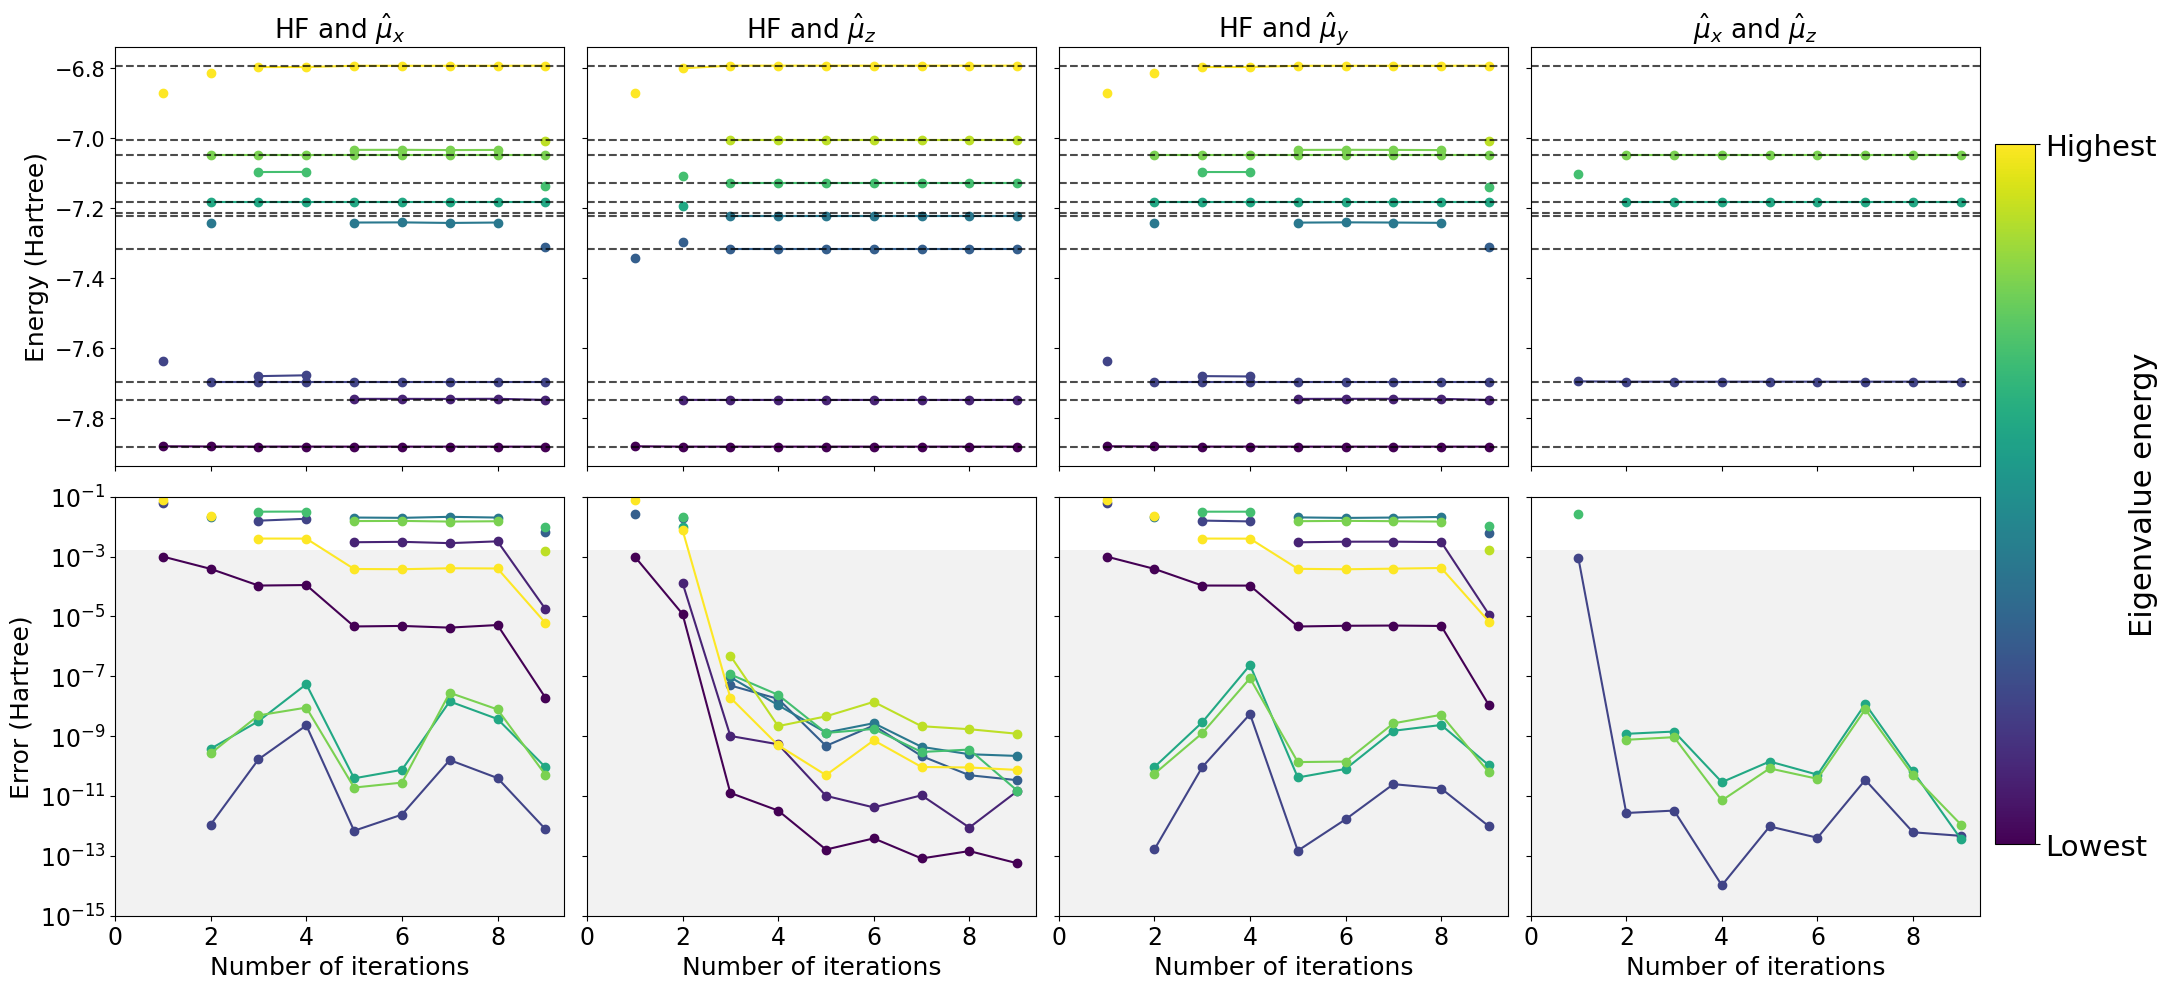

In [7]:

# --- Configs ---
Nstates = 11
num_tracks_per_state = 5
K = 10
steps = 15
colors = plt.colormaps['viridis'](np.linspace(0, 1, Nstates))
norm = Normalize(vmin=0, vmax=10)
cmap = plt.colormaps['viridis']
size = 256

# --- Normalize operator and compute exponential ---
randm = matrix_op
norm_val = np.linalg.norm(randm, 2)
rand = randm / norm_val
exp = linalg.expm(-1j * rand * 3)

# --- Eigen decomposition ---
eigvals = np.unique(np.round(result.eigenvalues, 12))

# --- Initial states ---
init_states = [
    np.array([Statevector(hf_state).data, excited_state]),
    np.array([Statevector(hf_state).data, excited_state_z]),
    np.array([Statevector(hf_state).data, excited_state_y]),
    np.array([excited_state, excited_state]),
]

plt.figure(figsize=(20, 10))
index_p = 1

# --- Evolution tracking ---
for states in init_states:
    Ninitial = len(states)
    T ,S = create_T_S_block_numerical(states, exp, steps)

    list_eigs = [[] for _ in range(num_tracks_per_state * Nstates)]
    list_iter = [[] for _ in range(num_tracks_per_state * Nstates)]

    for i in range(1, K):
        Ttemp = T[:3*i, :3*i]
        Stemp = S[:3*i, :3*i]

        # Generalized eigenvalue problem with SVD
        s, V, d = np.linalg.svd(Stemp)
        s, d = np.conj(s).T, np.conj(d).T
        Ttemp = d @ Ttemp @ s
        Stemp = d @ Stemp @ s

        idxs = np.where(V > 1e-10)[0]
        Ttemp, Stemp = Ttemp[idxs,:][:, idxs], Stemp[idxs,:][:, idxs]
        eigsv = linalg.eig(Ttemp, Stemp)[0]
        eigsv_angle = -np.angle(eigsv)
        eigsv_angle = eigsv_angle[(eigsv_angle < 3.000001) & (eigsv_angle > -2.9999999)] * norm_val / 3

        assigned_sublists = [set() for _ in range(Nstates)]

        for elem in eigsv_angle:
            near, idx = find_nearest(eigvals, elem)
            if idx >= Nstates:
                continue

            temp_diffs, valid_idxs = [], []
            for k in range(num_tracks_per_state):
                list_idx = num_tracks_per_state * idx + k

                # Skip if already assigned or duplicate iteration
                if list_idx in assigned_sublists[idx]:
                    continue
                if i in list_iter[list_idx]:
                    continue

                # Ensure continuity
                if len(list_iter[list_idx]) > 0 and i != list_iter[list_idx][-1] + 1:
                    continue

                valid_idxs.append(list_idx)

                if len(list_eigs[list_idx]) == 0:
                    temp_diffs.append(0.01)
                else:
                    prev_val = list_eigs[list_idx][-1]
                    temp_diffs.append(abs(prev_val - elem))

            if temp_diffs:
                best_idx = valid_idxs[np.argmin(temp_diffs)]
                list_eigs[best_idx].append(elem)
                list_iter[best_idx].append(i)
                assigned_sublists[idx].add(best_idx)

    # --- Plot Results ---
    for p in range(num_tracks_per_state * Nstates):
        state_idx = p // num_tracks_per_state

        plt.subplot(2, 4, index_p)
        plt.plot(list_iter[p],
                 np.array(list_eigs[p]) + result.extracted_transformer_energy + problem_reduced.nuclear_repulsion_energy,
                 '-o', color=colors[state_idx])

        plt.subplot(2, 4, index_p + 4)
        plt.plot(list_iter[p],
                 np.abs(np.array(list_eigs[p]) - eigvals[state_idx]),
                 '-o', color=colors[state_idx])

    plt.subplot(2, 4, index_p)
    for k in range(Nstates):
        plt.axhline(y=eigvals[k] + result.extracted_transformer_energy + problem_reduced.nuclear_repulsion_energy,
                    color='black', linestyle='--', alpha=0.7)

    index_p += 1

# --- Formatting Subplots ---
for i in range(1, 5):
    ax = plt.subplot(2, 4, i)
    ax.set_xticks(np.arange(0, 10, 2))
    ax.set_xticklabels([])
    

    if i == 1:
        ax.set_ylabel('Energy (Hartree)', fontsize=18)
        ax.set_title('HF and $\hat{\mu}_x$', fontsize=19)
        ax.tick_params('y', labelsize=15)
    elif i == 2:
        ax.set_title('HF and $\hat{\mu}_z$', fontsize=19)
    elif i == 3:
        ax.set_title('HF and $\hat{\mu}_y$', fontsize=19)
    elif i == 4:
        ax.set_title('$\hat{\mu}_x$ and $\hat{\mu}_z$', fontsize=19)

    if i > 1:
        ax.set_yticklabels([])
        ax.tick_params('y', labelsize=15, labelleft=False)

    ax_b = plt.subplot(2, 4, i + 4)
    ax_b.set_xlabel('Number of iterations', fontsize=18)
    ax_b.set_xticks(np.arange(0, 10, 2))
    ax_b.set_xticklabels(np.arange(0, 10, 2), size=17)
    ax_b.axhspan(0, 1.6e-3, facecolor='gray', alpha=0.1)
    ax_b.set_yscale('log')
    ax_b.set_ylim(1e-15, 1e-1)

    if i == 1:
        ax_b.set_ylabel('Error (Hartree)', fontsize=18)
        ax_b.tick_params('y', labelsize=17)
    else:
        ax_b.set_yticklabels([])
        ax_b.tick_params('y', labelsize=17, labelleft=False)

    

# --- Colorbar ---
fig = plt.gcf()
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[0, 10])
cbar_ax.set_yticklabels(['Lowest', 'Highest'])
cbar_ax.tick_params(labelsize=21)
cbar.set_label("Eigenvalue energy", fontsize=22, labelpad=-20)

plt.tight_layout()
plt.savefig(f'{Data_path}/LiH_3evol_2references_hip.pdf', format='pdf', bbox_inches='tight')
plt.show()

<>:120: SyntaxWarning: invalid escape sequence '\h'
<>:123: SyntaxWarning: invalid escape sequence '\h'
<>:125: SyntaxWarning: invalid escape sequence '\h'
<>:127: SyntaxWarning: invalid escape sequence '\h'
<>:120: SyntaxWarning: invalid escape sequence '\h'
<>:123: SyntaxWarning: invalid escape sequence '\h'
<>:125: SyntaxWarning: invalid escape sequence '\h'
<>:127: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_22270/3754794575.py:120: SyntaxWarning: invalid escape sequence '\h'
  ax.set_title('HF, $\hat{\mu}_y$ and $\hat{\mu}_x$', fontsize=19)
/tmp/ipykernel_22270/3754794575.py:123: SyntaxWarning: invalid escape sequence '\h'
  ax.set_title('HF, $\hat{\mu}_y$ and $\hat{\mu}_z$', fontsize=19)
/tmp/ipykernel_22270/3754794575.py:125: SyntaxWarning: invalid escape sequence '\h'
  ax.set_title('HF, $\hat{\mu}_x$ and $\hat{\mu}_z$', fontsize=19)
/tmp/ipykernel_22270/3754794575.py:127: SyntaxWarning: invalid escape sequence '\h'
  ax.set_title('$\hat{\mu}_x$, $\hat{\mu}_y$ an

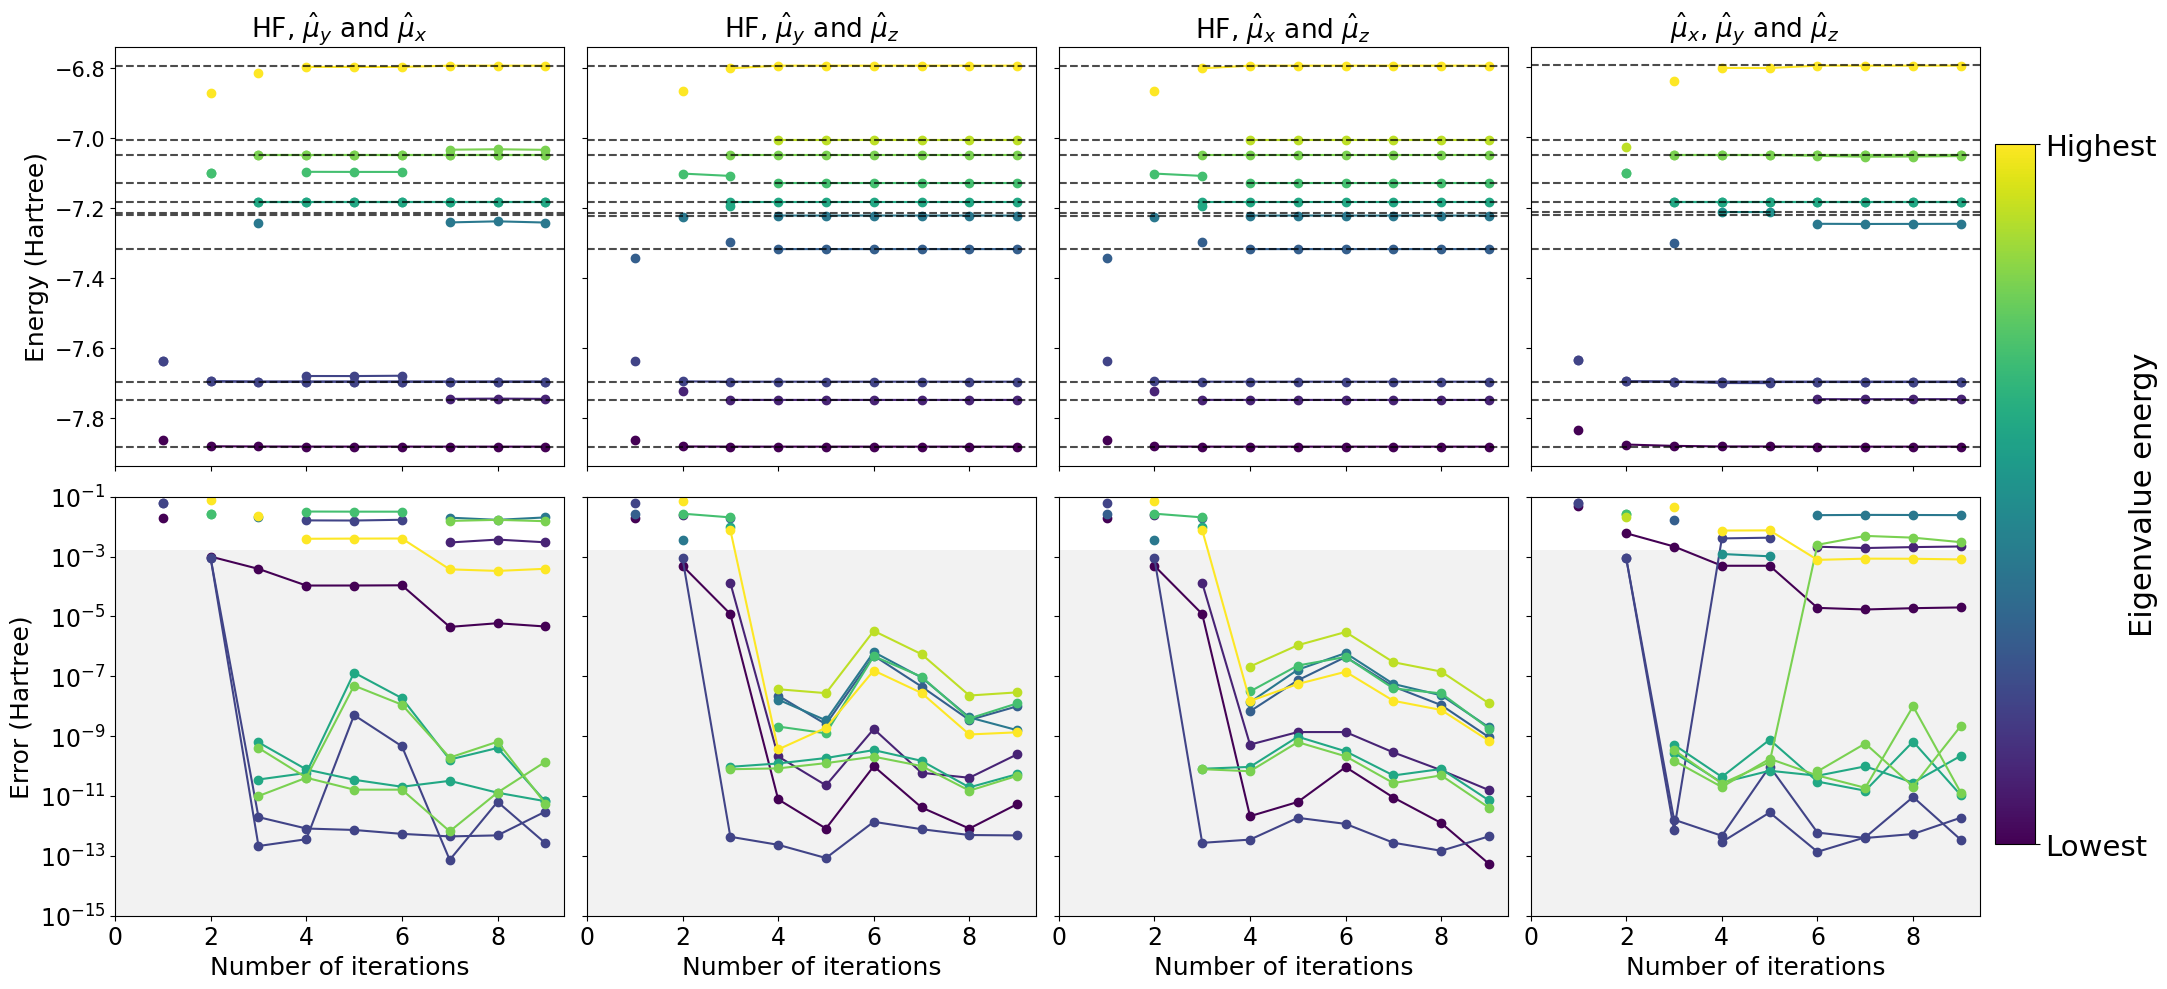

In [6]:

# --- Configs ---
Nstates = 11
num_tracks_per_state = 5
K = 10
steps = 15
colors = plt.colormaps['viridis'](np.linspace(0, 1, Nstates))
norm = Normalize(vmin=0, vmax=10)
cmap = plt.colormaps['viridis']
size = 256

# --- Normalize operator and compute exponential ---
randm = matrix_op
norm_val = np.linalg.norm(randm, 2)
rand = randm / norm_val
exp = linalg.expm(-1j * rand * 3)

# --- Eigen decomposition ---
eigvals = np.unique(np.round(result.eigenvalues, 12))

# --- Initial states ---
init_states = [
    np.array([Statevector(hf_state).data, excited_state, excited_state_y]),
    np.array([Statevector(hf_state).data, excited_state_z, excited_state_y]),
    np.array([Statevector(hf_state).data, excited_state_z, excited_state]),
    np.array([excited_state, excited_state_z, excited_state_y]),
]

plt.figure(figsize=(20, 10))
index_p = 1

# --- Evolution tracking ---
for states in init_states:
    Ninitial = len(states)
    T ,S = create_T_S_block_numerical(states, exp, steps)

    list_eigs = [[] for _ in range(num_tracks_per_state * Nstates)]
    list_iter = [[] for _ in range(num_tracks_per_state * Nstates)]

    for i in range(1, K):
        Ttemp = T[:3*i, :3*i]
        Stemp = S[:3*i, :3*i]

        # Generalized eigenvalue problem with SVD
        s, V, d = np.linalg.svd(Stemp)
        s, d = np.conj(s).T, np.conj(d).T
        Ttemp = d @ Ttemp @ s
        Stemp = d @ Stemp @ s

        idxs = np.where(V > 1e-10)[0]
        Ttemp, Stemp = Ttemp[idxs,:][:, idxs], Stemp[idxs,:][:, idxs]
        eigsv = linalg.eig(Ttemp, Stemp)[0]
        eigsv_angle = -np.angle(eigsv)
        eigsv_angle = eigsv_angle[(eigsv_angle < 3.000001) & (eigsv_angle > -2.9999999)] * norm_val / 3

        assigned_sublists = [set() for _ in range(Nstates)]

        for elem in eigsv_angle:
            near, idx = find_nearest(eigvals, elem)
            if idx >= Nstates:
                continue

            temp_diffs, valid_idxs = [], []
            for k in range(num_tracks_per_state):
                list_idx = num_tracks_per_state * idx + k

                # Skip if already assigned or duplicate iteration
                if list_idx in assigned_sublists[idx]:
                    continue
                if i in list_iter[list_idx]:
                    continue

                # Ensure continuity
                if len(list_iter[list_idx]) > 0 and i != list_iter[list_idx][-1] + 1:
                    continue

                valid_idxs.append(list_idx)

                if len(list_eigs[list_idx]) == 0:
                    temp_diffs.append(0.01)
                else:
                    prev_val = list_eigs[list_idx][-1]
                    temp_diffs.append(abs(prev_val - elem))

            if temp_diffs:
                best_idx = valid_idxs[np.argmin(temp_diffs)]
                list_eigs[best_idx].append(elem)
                list_iter[best_idx].append(i)
                assigned_sublists[idx].add(best_idx)

    # --- Plot Results ---
    for p in range(num_tracks_per_state * Nstates):
        state_idx = p // num_tracks_per_state

        plt.subplot(2, 4, index_p)
        plt.plot(list_iter[p],
                 np.array(list_eigs[p]) + result.extracted_transformer_energy + problem_reduced.nuclear_repulsion_energy,
                 '-o', color=colors[state_idx])

        plt.subplot(2, 4, index_p + 4)
        plt.plot(list_iter[p],
                 np.abs(np.array(list_eigs[p]) - eigvals[state_idx]),
                 '-o', color=colors[state_idx])

    plt.subplot(2, 4, index_p)
    for k in range(Nstates):
        plt.axhline(y=eigvals[k] + result.extracted_transformer_energy + problem_reduced.nuclear_repulsion_energy,
                    color='black', linestyle='--', alpha=0.7)

    index_p += 1

# --- Formatting Subplots ---
for i in range(1, 5):
    ax = plt.subplot(2, 4, i)
    ax.set_xticks(np.arange(0, 10, 2))
    ax.set_xticklabels([])
    

    if i == 1:
        ax.set_ylabel('Energy (Hartree)', fontsize=18)
        ax.set_title('HF, $\hat{\mu}_y$ and $\hat{\mu}_x$', fontsize=19)
        ax.tick_params('y', labelsize=15)
    elif i == 2:
        ax.set_title('HF, $\hat{\mu}_y$ and $\hat{\mu}_z$', fontsize=19)
    elif i == 3:
        ax.set_title('HF, $\hat{\mu}_x$ and $\hat{\mu}_z$', fontsize=19)
    elif i == 4:
        ax.set_title('$\hat{\mu}_x$, $\hat{\mu}_y$ and $\hat{\mu}_z$', fontsize=19)

    if i > 1:
        ax.set_yticklabels([])
        ax.tick_params('y', labelsize=15, labelleft=False)

    ax_b = plt.subplot(2, 4, i + 4)
    ax_b.set_xlabel('Number of iterations', fontsize=18)
    ax_b.set_xticks(np.arange(0, 10, 2))
    ax_b.set_xticklabels(np.arange(0, 10, 2), size=17)
    ax_b.axhspan(0, 1.6e-3, facecolor='gray', alpha=0.1)
    ax_b.set_yscale('log')
    ax_b.set_ylim(1e-15, 1e-1)

    if i == 1:
        ax_b.set_ylabel('Error (Hartree)', fontsize=18)
        ax_b.tick_params('y', labelsize=17)
    else:
        ax_b.set_yticklabels([])
        ax_b.tick_params('y', labelsize=17, labelleft=False)

    

# --- Colorbar ---
fig = plt.gcf()
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[0, 10])
cbar_ax.set_yticklabels(['Lowest', 'Highest'])
cbar_ax.tick_params(labelsize=21)
cbar.set_label("Eigenvalue energy", fontsize=22, labelpad=-20)

plt.tight_layout()
plt.savefig(f'{Data_path}/LiH_3evol_3references_hip.pdf', format='pdf', bbox_inches='tight')
plt.show()


### Qiskit Simulations

/tmp/ipykernel_1061/1790560210.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])  # leave room for colorbar


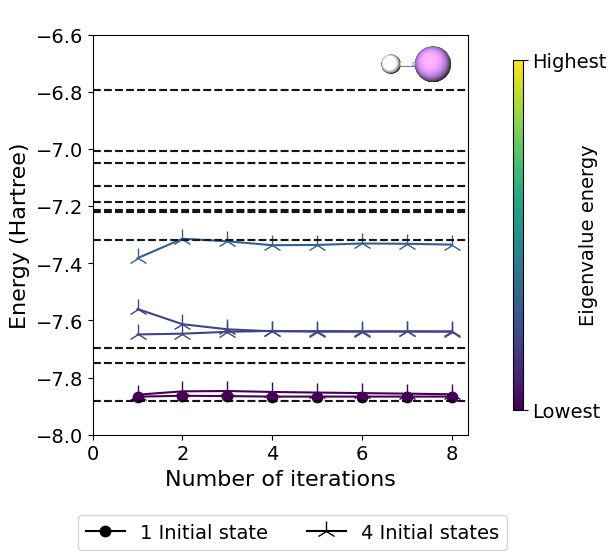

In [ ]:
Nstates = 10

colors = plt.colormaps['viridis'](np.linspace(0, 1, 11))  # normalize 0-1
norm = Normalize(vmin=0, vmax=10)
cmap = plt.colormaps['viridis']
ite = np.arange(0,10,2)
ite2 = np.arange(0,10,2)
markers_dict = {'1 Initial state': '.', '4 Initial states': '2'}
markers_handle = [mlines.Line2D([], [], color='black', label=f"{T}", marker=marker, markersize=15
                                ) for T, marker in markers_dict.items()]
line_handle = [mlines.Line2D([], [], color='black', linestyle='--', label='Exact energy', markersize=15)]
num_tracks_per_state = 5

# Box (patch) for the gray region
gray_region_handle = [mpatches.Patch(color='gray', alpha=0.1, label='Chemical accuracy')]
norm_val = np.linalg.norm(matrix_op,2)
eigv, eigvecs = linalg.eigh(matrix_op)
eigvals = np.sort(np.unique(np.round(result.eigenvalues, 12)))
markers = ['.', '2', 'x', '<', 'x']
shots_idx = 0
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.8])  # Leave room on right for colorbar
shots_idx = 0
shots = 100000

for state_group in ["4", "4_4"]:
    T = pkl.load(open(f'{Data_path}/QISKIT_T_LiH_2ndntrotter15_1evol_hf_{shots}_ensemble1vf15_ref{state_group}.pkl', 'rb'))
    S = pkl.load(open(f'{Data_path}/QISKIT_S_LiH_2ndntrotter15_1evol_hf_{shots}_ensemble1vf15_ref{state_group}.pkl', 'rb'))

    list_eigs = [[] for _ in range(num_tracks_per_state * Nstates)]
    list_iter = [[] for _ in range(num_tracks_per_state * Nstates)]

    max_iter = 10 if state_group == "_4" else 9
    factor = 1 if state_group == "_4" else 4

    for i in range(1, max_iter):
        Ttemp = T[:factor*i,:factor*i]
        Stemp = S[:factor*i,:factor*i]

        s,V,d = np.linalg.svd(Stemp)
        sd = np.conj(s).T
        dd = np.conj(d).T
        Ttemp = sd@Ttemp@dd
        Stemp = sd@(Stemp)@dd
        idxs = np.where(V > 0.1)[0]
        Ttemp = Ttemp[idxs,:][:,idxs]
        Stemp = Stemp[idxs,:][:,idxs]
        eigsv = linalg.eig(Ttemp,Stemp)[0]
        eigsv_angle = -np.angle(eigsv)
        eigsv_angle = eigsv_angle[np.where(eigsv_angle<1)]
        eigsv_angle = eigsv_angle[np.where(eigsv_angle>-1)] * norm_val / 1

        assigned_sublists = [set() for _ in range(Nstates)]
        for elem in eigsv_angle:
            near, idx = find_nearest(eigvals, elem)
            if idx >= Nstates:
                continue

            temp_diffs = []
            valid_idxs = []

            for k in range(num_tracks_per_state):
                list_idx = num_tracks_per_state * idx + k

                if list_idx in assigned_sublists[idx]:
                    continue
                if i in list_iter[list_idx]:
                    continue
                if len(list_iter[list_idx]) > 0 and i != list_iter[list_idx][-1] + 1:
                    continue

                valid_idxs.append(list_idx)
                if len(list_eigs[list_idx]) == 0:
                    temp_diffs.append(0.2)
                else:
                    prev_val = list_eigs[list_idx][-1]
                    temp_diffs.append(abs(prev_val - elem))

            if temp_diffs:
                best_idx = valid_idxs[np.argmin(temp_diffs)]
                list_eigs[best_idx].append(elem)
                list_iter[best_idx].append(i)
                assigned_sublists[idx].add(best_idx)

    col = 0 if state_group == "4" else 1
    for p in range(num_tracks_per_state * Nstates):
        if len(list_iter[p]) < 2:
            continue
        state_idx = p // num_tracks_per_state
        ax.plot(list_iter[p], list_eigs[p]+result.extracted_transformer_energy+problem_reduced.nuclear_repulsion_energy, marker=markers[shots_idx], color=colors[state_idx],markersize=15)
        # axs[1, col].plot(list_iter[p], np.abs(np.array(list_eigs[p]) - eigvals[state_idx]), marker=markers[shots_idx], color=colors[state_idx])

    for k in range(11):
        ax.axhline(y=eigvals[k]+result.extracted_transformer_energy+problem_reduced.nuclear_repulsion_energy, color='black', linestyle='--', alpha=0.7)

    shots_idx += 1


plt.ylabel('Energy (Hartree)', fontsize=16)
plt.xlabel('Number of iterations', fontsize=16)
plt.xticks(ite, size=14)
plt.yticks(size=14)
plt.ylim(-8, -6.6)


# -------- COLORBAR --------


sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[0, 10])
cbar.ax.set_yticklabels(['Lowest', 'Highest'], fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar.set_label("Eigenvalue energy", fontsize=14, labelpad=-20)

# -------- LEGEND --------
fig.legend(handles=markers_handle, loc='lower center', fontsize=14,
           bbox_to_anchor=(0.5, -0.15), ncol=2)
# -------- IMAGE IN TOP-RIGHT CORNER --------
img_path = f'LIH.png'  # Replace with your actual PNG filename
img = mpimg.imread(img_path)
imagebox = OffsetImage(img, zoom=0.4)  # Adjust zoom as needed

# Coordinates in axis fraction (1,1) = top-right corner of the Axes
ab = AnnotationBbox(imagebox, (1, 1.05), xycoords='axes fraction',
                    box_alignment=(1, 1), frameon=False)
ax.add_artist(ab)

# Layout
plt.tight_layout(rect=[0, 0, 0.95, 1])  # leave room for colorbar
plt.savefig(f'{Data_path}/figure8.pdf', dpi=300, bbox_inches='tight',format='pdf')
plt.show()

/tmp/ipykernel_1061/1337147673.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])  # leave room for colorbar


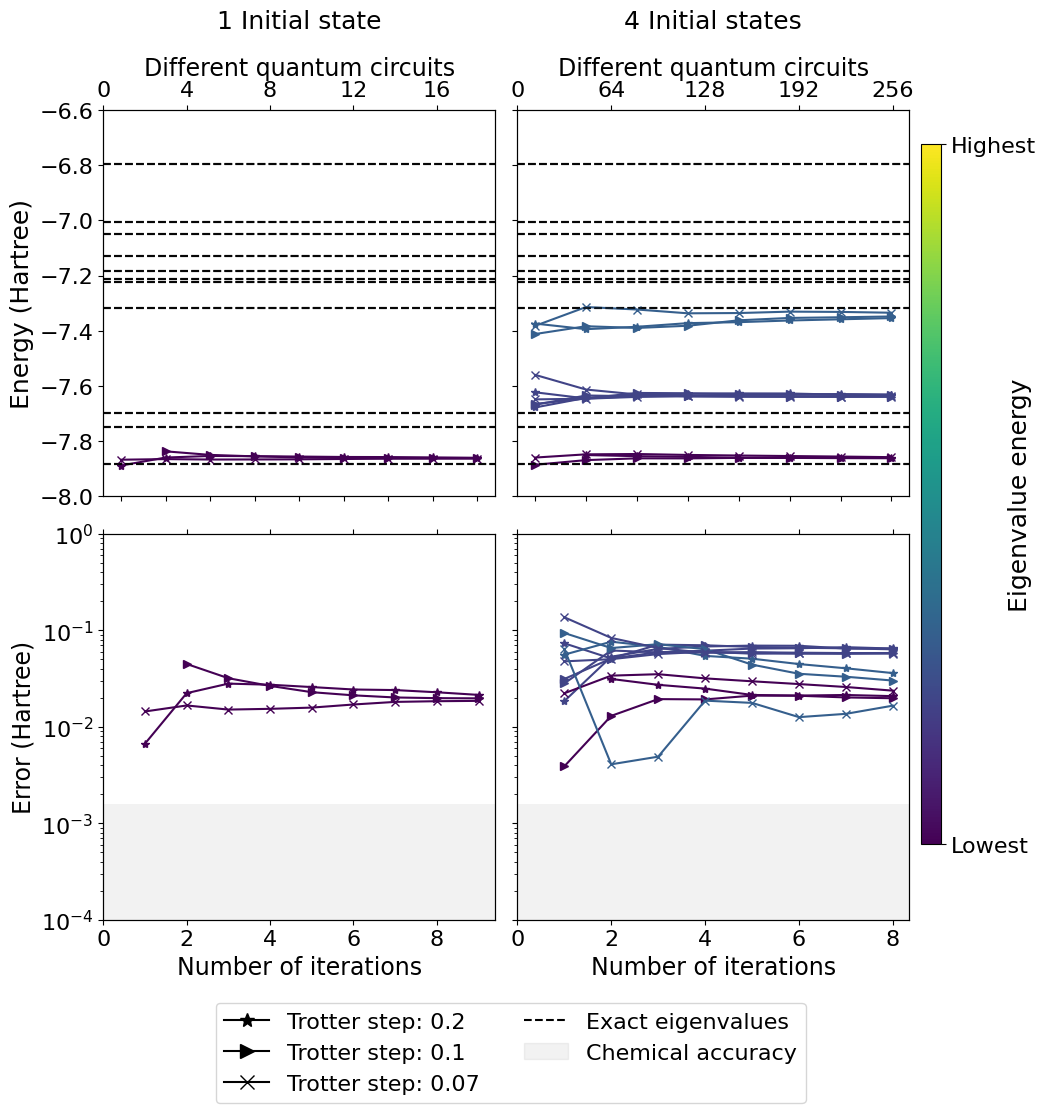

In [8]:
Nstates = 10

colors = plt.colormaps['viridis'](np.linspace(0, 1, 11))  # normalize 0-1
norm = Normalize(vmin=0, vmax=10)
cmap = plt.colormaps['viridis']
ite = np.arange(0,10,2)
ite2 = np.arange(0,10,2)
ite3 = np.arange(0,10,1)
markers_dict = {'Trotter step: 0.2': '*', 'Trotter step: 0.1': '>', 'Trotter step: 0.07': 'x'}
markers_handle = [mlines.Line2D([], [], color='black', label=f"{T}", marker=marker, markersize=10) for T, marker in markers_dict.items()]
line_handle = [mlines.Line2D([], [], color='black', linestyle='--', label='Exact eigenvalues', markersize=10)]
num_tracks_per_state = 5


# Box (patch) for the gray region
gray_region_handle = [mpatches.Patch(color='gray', alpha=0.1, label='Chemical accuracy')]
norm_val = np.linalg.norm(matrix_op,2)
eigv, eigvecs = linalg.eigh(matrix_op)
eigvals = np.sort(np.unique(np.round(result.eigenvalues, 12)))
markers = ['*', '>', 'x', '<', 'x']
shots_idx = 0
fig, axs = plt.subplots(2,2,figsize=(10, 10))
for ref_suffix, x, col_idx in [('ref4', 1, 0), ('ref4_4', 4, 1)]:
    shots_idx = 0
    for shots in [5, 10, 15]:
        T = pkl.load(open(f'{Data_path}/QISKIT_T_LiH_2ndntrotter{shots}_1evol_hf_{100000}_ensemble1vf15_{ref_suffix}.pkl', 'rb'))
        S = pkl.load(open(f'{Data_path}/QISKIT_S_LiH_2ndntrotter{shots}_1evol_hf_{100000}_ensemble1vf15_{ref_suffix}.pkl', 'rb'))

        list_eigs = [[] for _ in range(num_tracks_per_state * Nstates)]
        list_iter = [[] for _ in range(num_tracks_per_state * Nstates)]

        max_iter = 10 if x == 1 else 9

        for i in range(1, max_iter):
            dim = x * i
            Ttemp = T[:dim, :dim]
            Stemp = S[:dim, :dim]

            s, V, d = np.linalg.svd(Stemp)
            sd = np.conj(s).T
            dd = np.conj(d).T
            Ttemp = sd @ Ttemp @ dd
            Stemp = sd @ Stemp @ dd

            idxs = np.where(V > 0.1)[0]
            Ttemp = Ttemp[idxs, :][:, idxs]
            Stemp = Stemp[idxs, :][:, idxs]

            eigsv = linalg.eig(Ttemp, Stemp)[0]
            eigsv_angle = -np.angle(eigsv)
            eigsv_angle = eigsv_angle[(eigsv_angle < 1) & (eigsv_angle > -1)] * norm_val

            assigned_sublists = [set() for _ in range(Nstates)]
            for elem in eigsv_angle:
                near, idx = find_nearest(eigvals, elem)
                if idx >= Nstates:
                    continue

                temp_diffs = []
                valid_idxs = []

                for k in range(num_tracks_per_state):
                    list_idx = num_tracks_per_state * idx + k

                    if list_idx in assigned_sublists[idx]:
                        continue
                    if i in list_iter[list_idx]:
                        continue
                    if list_iter[list_idx] and i != list_iter[list_idx][-1] + 1:
                        continue

                    valid_idxs.append(list_idx)

                    if not list_eigs[list_idx]:
                        temp_diffs.append(0.2 if x == 1 else 0.1)
                    else:
                        prev_val = list_eigs[list_idx][-1]
                        temp_diffs.append(abs(prev_val - elem))

                if temp_diffs:
                    best_idx = valid_idxs[np.argmin(temp_diffs)]
                    list_eigs[best_idx].append(elem)
                    list_iter[best_idx].append(i)
                    assigned_sublists[idx].add(best_idx)

        # --- Plot Results ---
        for p in range(num_tracks_per_state * Nstates):
            if len(list_iter[p]) < 2:
                continue
            state_idx = p // num_tracks_per_state

            axs[0, col_idx].plot(
                list_iter[p],
                np.array(list_eigs[p]) + result.extracted_transformer_energy + problem_reduced.nuclear_repulsion_energy,
                marker=markers[shots_idx],
                color=colors[state_idx]
            )

            axs[1, col_idx].plot(
                list_iter[p],
                np.abs(np.array(list_eigs[p]) - eigvals[state_idx]),
                marker=markers[shots_idx],
                color=colors[state_idx]
            )

        for k in range(11):
            axs[0, col_idx].axhline(
                y=eigvals[k] + result.extracted_transformer_energy +problem_reduced.nuclear_repulsion_energy,
                color='black',
                linestyle='--',
                alpha=0.7
            )

        shots_idx += 1

axs[0, 0].set_title('1 Initial state', fontsize=18, pad=20)
axs[0, 0].set_ylabel('Energy (Hartree)', fontsize=18)
axs[0, 0].set_ylim(-8, -6.6)
axs[0, 0].tick_params(axis='x', labelbottom=False)  # show ticks, hide labels
axs[0, 0].tick_params(axis='y', labelsize=16)

# -------- TOP RIGHT --------
axs[0, 1].set_title('4 Initial states', fontsize=18, pad=20)
axs[0, 1].set_ylim(-8, -6.6)
axs[0, 1].tick_params(axis='x', labelbottom=False)
axs[0, 1].tick_params(axis='y', labelleft=False, labelright=False, labelsize=16)

# Top x-axis for quantum circuits on bottom-left plot
ax_top = axs[0, 1].twiny()
ax_top.set_xlim(axs[0, 1].get_xlim())
ax_top.set_xticks(ite)
ax_top.set_xticklabels([2 * x*4**2 for x in ite], fontsize=16)
ax_top.set_xlabel("Different quantum circuits", fontsize=17)
ax_top.tick_params(axis='x', direction='out')

# -------- BOTTOM LEFT --------
axs[1, 0].set_xlabel('Number of iterations', fontsize=17)
axs[1, 0].set_ylabel('Error (Hartree)', fontsize=17)
axs[1, 0].set_xticks(ite)
axs[1, 0].set_xticklabels(ite, fontsize=16)
axs[1, 0].tick_params(axis='y', labelsize=16)
axs[1, 0].set_yscale('log')
axs[1, 0].set_ylim(1e-4, 1)
axs[1, 0].axhspan(0, 1.6e-3, facecolor='gray', alpha=0.1)

# Top x-axis for quantum circuits on bottom-left plot
ax_top = axs[0, 0].twiny()
ax_top.set_xlim(axs[0, 0].get_xlim())
ax_top.set_xticks(ite2)
ax_top.set_xticklabels([2 * x for x in ite2], fontsize=16)
ax_top.set_xlabel("Different quantum circuits", fontsize=17)
ax_top.tick_params(axis='x', direction='out')

# -------- BOTTOM RIGHT --------
axs[1, 1].set_xlabel('Number of iterations', fontsize=17)
axs[1, 1].set_xticks(ite)
axs[1, 1].set_xticklabels(ite, fontsize=16)
axs[1, 1].set_yscale('log')
axs[1, 1].set_ylim(1e-4, 1)
axs[1, 1].tick_params(axis='y', labelleft=False, labelright=False, labelsize=16)
axs[1, 1].axhspan(0, 1.6e-3, facecolor='gray', alpha=0.1)
# top ticks with labels
ax_top = axs[1, 0].twiny()
ax_top.set_xlim(axs[1, 0].get_xlim())
ax_top.set_xticks(ite2)
ax_top.set_xticklabels([])
ax_top = axs[1, 1].twiny()
ax_top.set_xlim(axs[1, 1].get_xlim())
ax_top.set_xticks(ite)
ax_top.set_xticklabels([])
# -------- COLORBAR --------
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[0, 10])
cbar.ax.set_yticklabels(['Lowest', 'Highest'], fontsize=16)
cbar.ax.tick_params(labelsize=16)
cbar.set_label("Eigenvalue energy", fontsize=18, labelpad=-20)

# -------- LEGEND --------
fig.legend(handles=markers_handle+line_handle+gray_region_handle, loc='lower center', fontsize=16,
           bbox_to_anchor=(0.53, -0.12), ncol=2)

# Layout
plt.tight_layout(rect=[0, 0, 0.95, 1])  # leave room for colorbar
plt.savefig(f'{Data_path}/figure13.pdf', dpi=300, bbox_inches='tight',format='pdf')
plt.show()

# HF - plots and analysis


In [9]:
# Problem Setup
problem_reduced, qubit_op, matrix_op, coefs, paulis, hf_state = diatomic_molecule_Hamiltonian(['F', 'H'], 0.91)
mapper = ParityMapper(problem_reduced.num_particles)

In [10]:
algo = NumPyEigensolver(k=276)
algo.filter_criterion = problem_reduced.get_default_filter_criterion()
solver = ExcitedStatesEigensolver(mapper, algo)
result = solver.solve(problem_reduced)

print(f"Total ground state energy = {result.total_energies[0]:.4f}")
print(f"Total first excited state energy = {result.total_energies[1]:.3f}")
print(f"Total second excited state energy = {result.total_energies[2]:.3f}")

Total ground state energy = -98.5952
Total first excited state energy = -98.109
Total second excited state energy = -98.109


In [11]:
# Retrieve the dipole moment property
dipole_property = problem_reduced.properties.electronic_dipole_moment


dipole_operators = dipole_property.second_q_ops()
dip_x = dipole_operators['XDipole']
dip_y = dipole_operators['YDipole']
dip_z = dipole_operators['ZDipole']
   

qubit_op_dipole = mapper.map(dip_x)
qubit_op_dipole = qubit_op_dipole.to_matrix()
excited_state = qubit_op_dipole@Statevector(hf_state).data
qubit_op_y = mapper.map(dip_y)
qubit_op_y = qubit_op_y.to_matrix()

excited_state_y = qubit_op_y@Statevector(hf_state).data

qubit_op_z = mapper.map(dip_z)
qubit_op_z = qubit_op_z.to_matrix()
excited_state_z = qubit_op_z@Statevector(hf_state).data

### Time evolution

/tmp/ipykernel_22270/2359027866.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


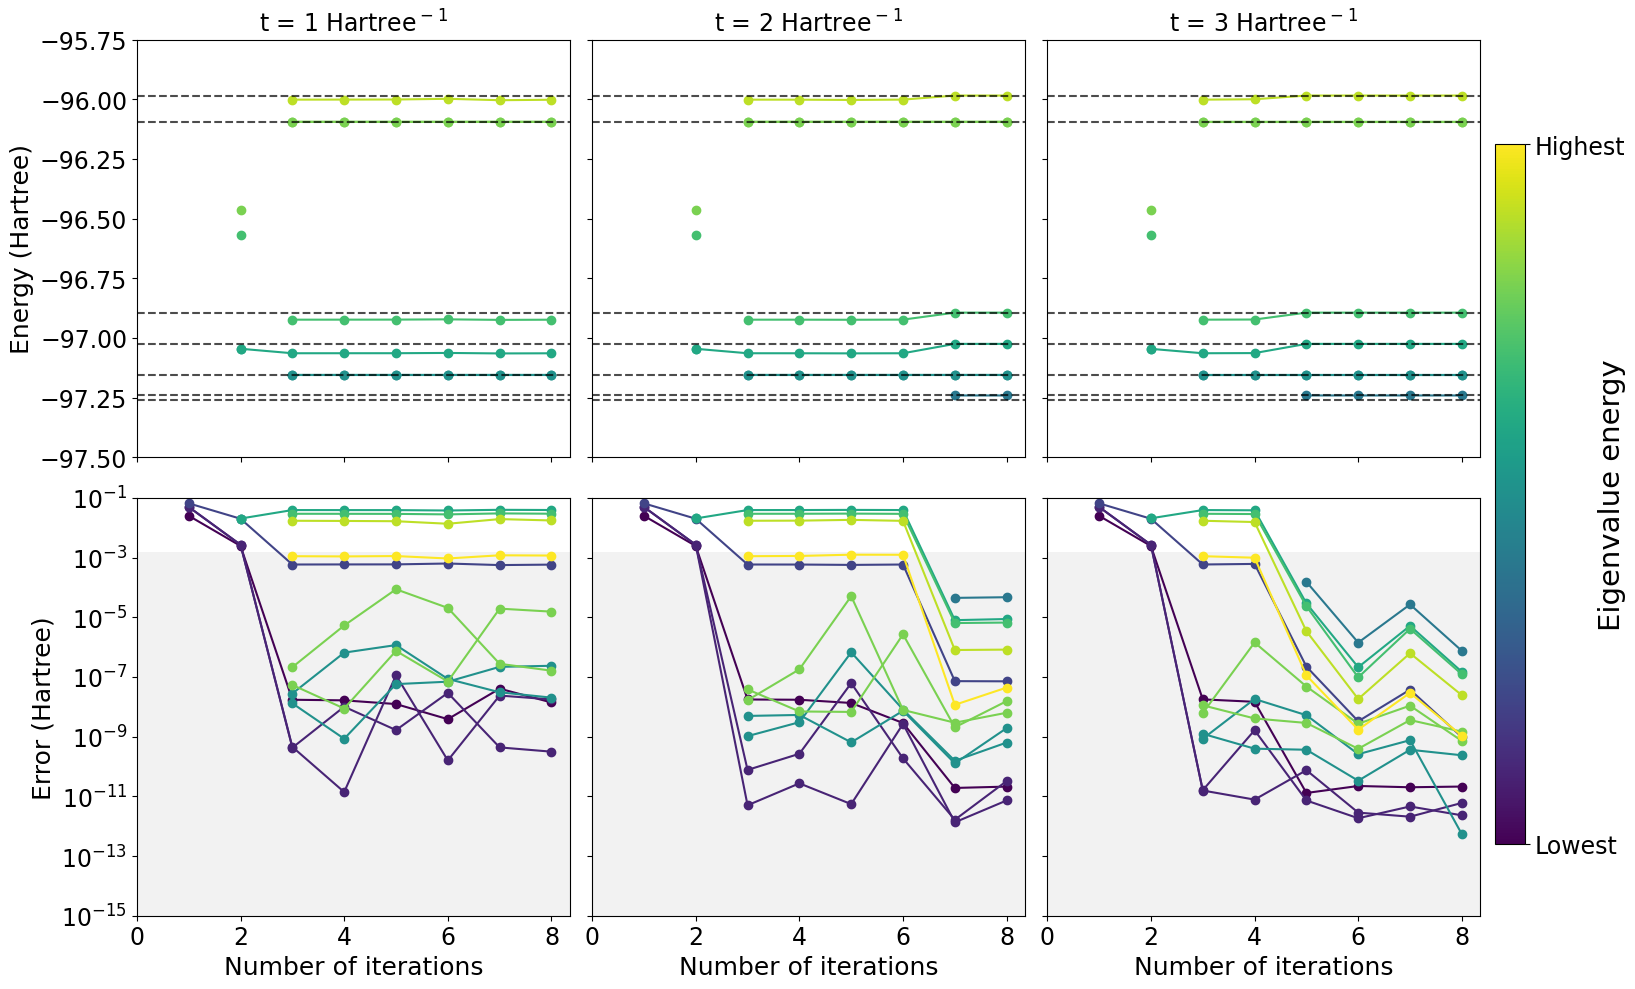

In [46]:


# --- Parameters ---
size = 256
colors = plt.colormaps['viridis'](np.linspace(0, 1, 11))
norm = Normalize(vmin=0, vmax=10)
cmap = plt.colormaps['viridis']
Nstates = 11
num_tracks_per_state = 5

# --- Normalize matrix and calculate exponentials ---
randm = matrix_op
norm_val = np.linalg.norm(randm, 2)
rand = randm / norm_val


# --- Diagonalization ---
eigvals = np.sort(np.unique(np.round(result.eigenvalues, 10)))

# --- Initial States ---
hf_sv = Statevector(hf_state).data
state3 = np.array([hf_sv, excited_state, excited_state_y, excited_state_z])

# --- Plot setup ---
plt.figure(figsize=(15, 10))
index_p = 1

# --- Evolution Loop ---
for evol in [1, 2, 3]:
    exp = linalg.expm(-1j * rand * evol)
    Ninitial = 4
    
    T, S = create_T_S_block_numerical(state3, exp, 9)
    ite = np.arange(0, 9, 2)
    ite2 = np.arange(0, 9, 2)

    list_eigs = [[] for _ in range(num_tracks_per_state * Nstates)]
    list_iter = [[] for _ in range(num_tracks_per_state * Nstates)]

    for i in range(1, 9):
        #print(i, Ninitial)
        dim = 4 * i
        Ttemp = T[:dim, :dim]
        Stemp = S[:dim, :dim]

        # SVD-based diagonalization
        s, V, d = np.linalg.svd(Stemp)
        Ttemp = np.conj(d.T) @ Ttemp @ np.conj(s.T)
        Stemp = np.conj(d.T) @ Stemp @ np.conj(s.T)

        # Remove near-zero components
        idxs = np.where(V > 1e-10)[0]
        Ttemp, Stemp = Ttemp[idxs,:][:, idxs], Stemp[idxs,:][:, idxs]

        eigsv = linalg.eig(Ttemp, Stemp)[0]
        eigsv_angle = -np.angle(eigsv)
        mask = (eigsv_angle < evol + 1e-6) & (eigsv_angle > -evol - 1e-6)
        eigsv_angle = eigsv_angle[mask] * norm_val / evol

        #print(np.sort(eigsv_angle))

        assigned_sublists = [set() for _ in range(Nstates)]
        for elem in eigsv_angle:
            near, idx = find_nearest(eigvals, elem)
            if idx >= Nstates:
                continue

            temp_diffs = []
            valid_idxs = []
            for k in range(num_tracks_per_state):
                list_idx = num_tracks_per_state * idx + k

                if list_idx in assigned_sublists[idx]:
                    continue
                if i in list_iter[list_idx]:
                    continue
                if list_iter[list_idx] and i != list_iter[list_idx][-1] + 1:
                    continue

                valid_idxs.append(list_idx)
                last_val = list_eigs[list_idx][-1] if list_eigs[list_idx] else 0
                temp_diffs.append(abs(last_val - elem) if list_eigs[list_idx] else 0.1)

            if temp_diffs:
                best_idx = valid_idxs[np.argmin(temp_diffs)]
                list_eigs[best_idx].append(elem)
                list_iter[best_idx].append(i)
                assigned_sublists[idx].add(best_idx)

    # --- Plot Energy and Error ---
    for p in range(num_tracks_per_state * Nstates):
        state_idx = p // num_tracks_per_state

        plt.subplot(2, 3, index_p)
        plt.plot(list_iter[p], np.array(list_eigs[p]) + result.extracted_transformer_energy + problem_reduced.nuclear_repulsion_energy, '-o',
                 color=colors[state_idx])

        plt.subplot(2, 3, index_p + 3)
        plt.plot(list_iter[p], np.abs(np.array(list_eigs[p]) - eigvals[state_idx]), '-o',
                 color=colors[state_idx])

    plt.subplot(2, 3, index_p)
    for k in range(11):
        plt.axhline(y=eigvals[k] + result.extracted_transformer_energy + problem_reduced.nuclear_repulsion_energy, color='black', linestyle='--', alpha=0.7)

    index_p += 1

# --- Axis Formatting ---
for i in range(1, 4):
    ax = plt.subplot(2, 3, i)
    if i == 1:
        ax.set_ylabel('Energy (Hartree)', fontsize=18)
    else:
        ax.set_yticklabels([])
        ax.tick_params(labelleft=False)
    ax.set_ylim(-97.5, -95.75)
    ax.set_title(f't = {i} Hartree$^-$$^1$', fontsize=17)
    ax.set_xticks(ite)
    ax.set_xticklabels([])
    ax.tick_params('y', labelsize=17)

    ax = plt.subplot(2, 3, i + 3)
    ax.set_xlabel('Number of iterations', fontsize=18)
    if i == 1:
        ax.set_ylabel('Error (Hartree)', fontsize=18)
    else:
        ax.set_yticklabels([])
        ax.tick_params(labelleft=False)

    ax.set_xticks(ite)
    ax.set_xticklabels(ite, size=17)
    ax.axhspan(0, 1.6e-3, facecolor='gray', alpha=0.1)
    ax.set_yscale('log')
    ax.set_ylim(1e-15, 1e-1)
    ax.tick_params('y', labelsize=17)

  

# --- Colorbar ---
fig = plt.gcf()
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[0, 10])
cbar_ax.set_yticklabels(['Lowest', 'Highest'])
cbar_ax.tick_params(labelsize=17)
cbar.set_label("Eigenvalue energy", fontsize=21, labelpad=-20)

plt.subplots_adjust(hspace=0.1)
plt.tight_layout()
plt.savefig(f'{Data_path}/HF_123evol_4referencesv5F.pdf', format='pdf', bbox_inches='tight')
plt.show()


### Precision limited

/tmp/ipykernel_22270/2679847412.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


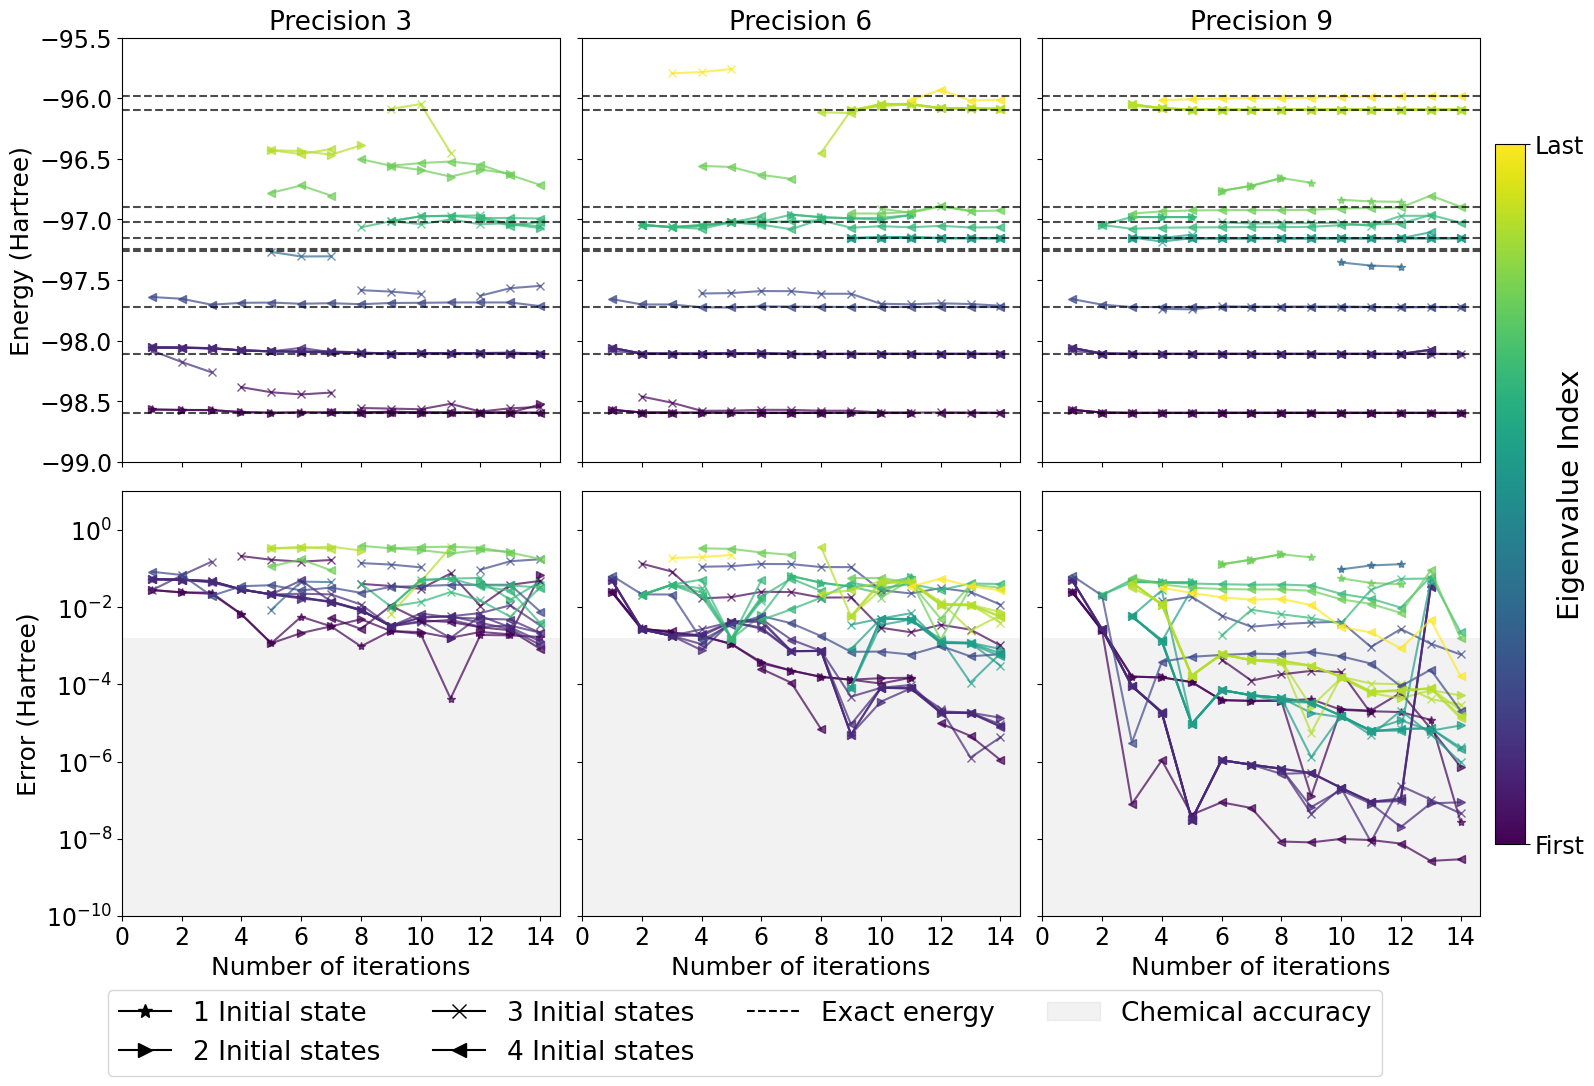

In [36]:

colors = plt.colormaps['viridis'](np.linspace(0, 1, 10))  # normalize 0-1
norm = Normalize(vmin=0, vmax=9)
cmap = plt.colormaps['viridis']
markers = ['*', '>', 'x', '<', 'x']
markers_dic = {f'1 Initial state': markers[0],
                f'2 Initial states': markers[1],
                f'3 Initial states': markers[2],
                f'4 Initial states': markers[3]}
gray_region_handle = [mpatches.Patch(color='gray', alpha=0.1, label='Chemical accuracy')]
line_handle = [mlines.Line2D([], [], color='black',linestyle='--', label='Exact energy')] 
overlap_handles = [mlines.Line2D([], [], color='black', label=f"{T}", marker=marker, markersize=10) for T, marker in markers_dic.items()] +line_handle+ gray_region_handle
plt.figure(figsize=(15, 10))
index_p = 1
randm = matrix_op
size = 256
norm_val = np.linalg.norm(randm,2)
rand = randm/norm_val # Normalize it
exp = linalg.expm(-1j *rand*3)  # Compute the unitary time evolution operator
eigvals, eigvecs = linalg.eigh(randm) 
eigvals = np.sort(eigvals)
eigvals = np.unique(np.round(result.eigenvalues,10))


state = np.array([Statevector(hf_state).data])
state2 = np.array([Statevector(hf_state).data,excited_state])
state3 = np.array([Statevector(hf_state).data,excited_state,excited_state_y,excited_state_z])
state4 = np.array([excited_state,excited_state_y,excited_state_z])
Nstates = 10  # Number of eigenstates to track
Ninitial = 2  # Number of initial states
num_tracks_per_state = 5 # Number of tracks per state
evol =3
for prec in [3,6,9]:
    for ii,ref in enumerate([state,state2,state4,state3]):
        Ninitial = len(ref)
        T, S = create_T_S_block_numerical(ref,exp,15)
        T = np.round(T,prec)
        S = np.round(S,prec)
        ite = np.arange(0,15,2)
        ite2 = np.arange(0,15,2)
        list_eigs = [[] for _ in range(num_tracks_per_state * Nstates)]
        list_iter = [[] for _ in range(num_tracks_per_state * Nstates)]
        for i in range(1,15):
         
            Ttemp = T[:Ninitial*i,:Ninitial*i]
            Stemp = S[:Ninitial*i,:Ninitial*i]
            s,V,d = np.linalg.svd(Stemp)
            s = np.conj(s).T
            d = np.conj(d).T
            Ttemp = d@Ttemp@s
            Stemp = d@Stemp@s
            cutoff = 10**(-1*prec-1)	
            
            idxs = np.where(V > cutoff)[0]
            Ttemp = Ttemp[idxs,:][:,idxs]
            Stemp = Stemp[idxs,:][:,idxs]
            eigsv = linalg.eig(Ttemp,Stemp)[0]
            eigsv_angle = -np.angle(eigsv)
            eigsv_angle = eigsv_angle[np.where(eigsv_angle<evol+0.000001)]
            eigsv_angle = eigsv_angle[np.where(eigsv_angle>-evol-0.000001)] * norm_val / evol
           
            assigned_sublists = [set() for _ in range(Nstates)]  # Prevent reuse within same iteration

            # Assign each eigenvalue to a sublist
            for elem in eigsv_angle:
                
                near, idx = find_nearest(eigvals, elem)
               
      
                if idx >= Nstates:
                    continue
            # subset = assigned_sublists[idx]
                temp_diffs = []
                valid_idxs = []

                for k in range(num_tracks_per_state):
                    list_idx = num_tracks_per_state * idx + k

                    # Skip if already assigned or duplicate iteration
                    if list_idx in assigned_sublists[idx]:
                        continue
                    if i in list_iter[list_idx]:
                        continue

                    # Ensure continuity
                    if len(list_iter[list_idx]) > 0 and i != list_iter[list_idx][-1] + 1:
                        continue

                    valid_idxs.append(list_idx)

                    if len(list_eigs[list_idx]) == 0:
                        temp_diffs.append(0.1)
                    else:
                        prev_val = list_eigs[list_idx][-1]
                        temp_diffs.append(abs(prev_val - elem))

                # Assign to best-matching track
                if temp_diffs:
                    best_idx = valid_idxs[np.argmin(temp_diffs)]
                    list_eigs[best_idx].append(elem)
                    list_iter[best_idx].append(i)
                    assigned_sublists[idx].add(best_idx)

        # --- Plot Results ---
        for p in range(num_tracks_per_state * Nstates):
            if len(list_iter[p]) <3:
                continue
            state_idx = p // num_tracks_per_state

            plt.subplot(2, 3, index_p)
            plt.plot(list_iter[p], list_eigs[p]+result.extracted_transformer_energy+problem_reduced.nuclear_repulsion_energy,color=colors[state_idx],marker=markers[ii],alpha=0.7)


            plt.subplot(2, 3, index_p + 3)
            plt.plot(list_iter[p], np.abs(np.array(list_eigs[p]) - eigvals[state_idx]), color=colors[state_idx],marker=markers[ii],alpha=0.7)

    plt.subplot(2,3,index_p)
   
    for k in range(11):
            plt.axhline(y=eigvals[k]+result.extracted_transformer_energy+problem_reduced.nuclear_repulsion_energy, color='black', linestyle='--',alpha=0.7)
        
    index_p += 1

for i in range(1,4):

    axt= plt.subplot(2,3,i)
    if i == 1:
        axt.set_ylabel('Energy (Hartree)',fontsize=18)
        axt.tick_params('y', labelsize=17)  # set the size of the ticks
       
    
    if i > 1:
        axt.set_yticklabels([])
        axt.tick_params('y', labelsize=17,labelleft=False)  # set the size of the ticks
    axt.set_title(f'Precision {i*3}',fontsize=19)
    
    axt.set_xticks(ite)  # Make sure ticks are set
    axt.set_xticklabels([])  # Hide the tick labels on bottom x-axis
   
    plt.ylim(-99, -95.5)

    ax = plt.subplot(2,3,i+3)
    ax.set_xlabel('Number of iterations',fontsize=18)
    if i == 1:
        ax.set_ylabel('Error (Hartree)',fontsize=18)
        ax.tick_params('y', labelsize=17)  # set the size of the ticks
    if i > 1:
        ax.set_yticklabels([])
        ax.tick_params('y', labelsize=17,labelleft=False)

    ax.set_xticks(ite)
    ax.set_xticklabels(ite, size=17)  # set the size of the ticks
    
    
    ax.axhspan(0, 1.6e-3, facecolor='gray', alpha=0.1)
  
    plt.ylim(1e-10,1e1)
    ax.set_yscale('log')
    
plt.subplots_adjust(hspace=0.1)
fig = plt.gcf()
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# [left, bottom, width, height] 
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # Move right via `left` value
cbar = fig.colorbar(sm, cax=cbar_ax, ticks=[0, 9])
cbar_ax.set_yticklabels(['First', 'Last'])
cbar_ax.tick_params(labelsize=17)
cbar.set_label("Eigenvalue Index", fontsize=21, labelpad=-20)
plt.legend(handles=overlap_handles, loc='lower center', fontsize=19, ncol=4, bbox_to_anchor=(-25, -0.35))
plt.tight_layout()

# Save the figure
plt.savefig(f'{Data_path}/HFevol_1234references_preSpre1v4F.pdf',format='pdf', bbox_inches='tight')
plt.show()

### Correlation effects in molecular systems

In [12]:

size = 256

eigvals = np.unique(np.round(result.eigenvalues,12))

Nstates = 11  # Number of eigenstates to track
num_tracks_per_state = 5 # Number of tracks per state
evol =3
list_dist = [0.4,0.6,0.8,0.91,1.1,1.3,1.5,1.7,1.9]
listt_vals1 = [[] for _ in range(20)]
list_teo =[[] for _ in range(20)]
for dist_idx in range(len(list_dist)):
    dist = list_dist[dist_idx]
    problem_reduced, qubit_op, matrix_op, coefs, paulis, hf_state = diatomic_molecule_Hamiltonian(['F', 'H'], dist)
    mapper = ParityMapper(problem_reduced.num_particles)
    algo = NumPyEigensolver(k=276)
    algo.filter_criterion = problem_reduced.get_default_filter_criterion()
  
    solver = ExcitedStatesEigensolver(mapper, algo)
    result = solver.solve(problem_reduced)
    eigvals = np.unique(np.round(result.eigenvalues,10))
   
    jj = 0
    for elem in eigvals:
        
            list_teo[jj].append(elem+result.extracted_transformer_energy+ problem_reduced.nuclear_repulsion_energy)
            jj += 1
    # Retrieve the dipole moment property
    dipole_property = problem_reduced.properties.electronic_dipole_moment


    dipole_operators = dipole_property.second_q_ops()
    dip_x = dipole_operators['XDipole']
    dip_y = dipole_operators['YDipole']
    dip_z = dipole_operators['ZDipole']
      
    mapper = ParityMapper(problem_reduced.num_particles)

    qubit_op_dipole = mapper.map(dip_x)
    qubit_op_dipole = qubit_op_dipole.to_matrix()
    excited_state = qubit_op_dipole@Statevector(hf_state).data
    qubit_op_y = mapper.map(dip_y)
    qubit_op_y = qubit_op_y.to_matrix()

    excited_state_y = qubit_op_y@Statevector(hf_state).data

    qubit_op_z = mapper.map(dip_z)
    qubit_op_z = qubit_op_z.to_matrix()
    excited_state_z = qubit_op_z@Statevector(hf_state).data

    randm = matrix_op
    size = 256
    norm_val = np.linalg.norm(randm,2)
    #print(norm)
    rand = randm/norm_val # Normalize it
    exp = linalg.expm(-1j *rand*evol)
    state3 = np.array([Statevector(hf_state).data])
    Ninitial = 1
    
    T, S = create_T_S_block_numerical(state3,exp,144)
    
    list_eigs = [[] for _ in range(11)]
    list_iter = [[] for _ in range(11)]
    
    Ttemp = T
    Stemp = S
    s,V,d = np.linalg.svd(Stemp)
    s = np.conj(s).T
    d = np.conj(d).T
    Ttemp = d@Ttemp@s
    Stemp = d@Stemp@s
    idxs = np.where(V > 1e-10)[0]
    Ttemp = Ttemp[idxs,:][:,idxs]
    Stemp = Stemp[idxs,:][:,idxs]
    eigsv = linalg.eig(Ttemp,Stemp)[0]
    eigsv_angle = -np.angle(eigsv)
    eigsv_angle = eigsv_angle[np.where(eigsv_angle<evol+0.000001)]
    eigsv_angle = eigsv_angle[np.where(eigsv_angle>-evol-0.000001)] * norm_val / evol
    sorted_eigsv = np.sort(eigsv_angle)

    ii = 0
    list_idsx= []
    assigned_sublists = [set() for _ in range(Nstates)]  # Prevent reuse within same iteration

    # Assign each eigenvalue to a sublist
    for elem in eigsv_angle:
        
        near, idx = find_nearest(eigvals, elem)
       
        if idx >= Nstates:
            continue

        temp_diffs = []
        valid_idxs = []

       
        list_idx =  idx 

        # Skip if already assigned or duplicate iteration
        if list_idx in assigned_sublists[idx]:
            continue


        valid_idxs.append(list_idx)

        if len(list_eigs[list_idx]) == 0:
            temp_diffs.append(0.01)
        else:
            prev_val = list_eigs[list_idx][-1]
            temp_diffs.append(abs(prev_val - elem))

        # Assign to best-matching track
        if temp_diffs:
            best_idx = valid_idxs[np.argmin(temp_diffs)]
            list_eigs[best_idx].append(elem)

            assigned_sublists[best_idx].add(best_idx)
            listt_vals1[best_idx].append(elem+result.extracted_transformer_energy+ problem_reduced.nuclear_repulsion_energy)
        


In [13]:
size =256
eigvals = np.unique(np.round(result.eigenvalues,12))

Nstates = 11  # Number of eigenstates to track

num_tracks_per_state = 5 # Number of tracks per state
evol =3
list_dist = [0.4,0.6,0.8,0.91,1.1,1.3,1.5,1.7,1.9]
listt_vals4 = [[] for _ in range(20)]
list_teo =[[] for _ in range(20)]
for dist_idx in range(len(list_dist)):
    dist = list_dist[dist_idx]
    problem_reduced, qubit_op, matrix_op, coefs, paulis, hf_state = diatomic_molecule_Hamiltonian(['F', 'H'], dist)
    mapper = ParityMapper(problem_reduced.num_particles)
    algo = NumPyEigensolver(k=276)
    algo.filter_criterion = problem_reduced.get_default_filter_criterion()

    solver = ExcitedStatesEigensolver(mapper, algo)
    result = solver.solve(problem_reduced)
    eigvals = np.unique(np.round(result.eigenvalues,10))
    print(eigvals)
    jj = 0
    for elem in eigvals:
        
            list_teo[jj].append(elem+result.extracted_transformer_energy+ problem_reduced.nuclear_repulsion_energy)
            jj += 1
    # Retrieve the dipole moment property
    dipole_property = problem_reduced.properties.electronic_dipole_moment


    dipole_operators = dipole_property.second_q_ops()
    dip_x = dipole_operators['XDipole']
    dip_y = dipole_operators['YDipole']
    dip_z = dipole_operators['ZDipole']
  
    mapper = ParityMapper(problem_reduced.num_particles)

    qubit_op_dipole = mapper.map(dip_x)
    qubit_op_dipole = qubit_op_dipole.to_matrix()
    excited_state = qubit_op_dipole@Statevector(hf_state).data
    qubit_op_y = mapper.map(dip_y)
    qubit_op_y = qubit_op_y.to_matrix()

    excited_state_y = qubit_op_y@Statevector(hf_state).data

    qubit_op_z = mapper.map(dip_z)
    qubit_op_z = qubit_op_z.to_matrix()
    excited_state_z = qubit_op_z@Statevector(hf_state).data

    randm = matrix_op
    size = 256
    norm_val = np.linalg.norm(randm,2)
  
    rand = randm/norm_val # Normalize it
    exp = linalg.expm(-1j *rand*evol)
    state3 = np.array([Statevector(hf_state).data,excited_state,excited_state_y,excited_state_z])
    Ninitial = 4
    
    T, S = create_T_S_block_numerical(state3,exp,10)
    
    list_eigs = [[] for _ in range(11)]
    list_iter = [[] for _ in range(11)]
    
    Ttemp = T[:Ninitial*9,:Ninitial*9]
    Stemp = S[:Ninitial*9,:Ninitial*9]
    s,V,d = np.linalg.svd(Stemp)
    s = np.conj(s).T
    d = np.conj(d).T
    Ttemp = d@Ttemp@s
    Stemp = d@Stemp@s
    idxs = np.where(V > 1e-10)[0]
    Ttemp = Ttemp[idxs,:][:,idxs]
    Stemp = Stemp[idxs,:][:,idxs]
    eigsv = linalg.eig(Ttemp,Stemp)[0]
    eigsv_angle = -np.angle(eigsv)
    eigsv_angle = eigsv_angle[np.where(eigsv_angle<evol+0.000001)]
    eigsv_angle = eigsv_angle[np.where(eigsv_angle>-evol-0.000001)] * norm_val / evol
    sorted_eigsv = np.sort(eigsv_angle)

    ii = 0
    list_idsx= []
    assigned_sublists = [set() for _ in range(Nstates)]  # Prevent reuse within same iteration

    # Assign each eigenvalue to a sublist
    for elem in eigsv_angle:
        
        near, idx = find_nearest(eigvals, elem)
   
        if idx >= Nstates:
            continue

        temp_diffs = []
        valid_idxs = []

        list_idx =  idx 

        # Skip if already assigned or duplicate iteration
        if list_idx in assigned_sublists[idx]:
            continue

        else:
            valid_idxs.append(list_idx)

            if len(list_eigs[list_idx]) == 0:
                temp_diffs.append(0.01)
            else:
                prev_val = list_eigs[list_idx][-1]
                temp_diffs.append(abs(prev_val - elem))

            # Assign to best-matching track
            if temp_diffs:
                best_idx = valid_idxs[np.argmin(temp_diffs)]
                list_eigs[best_idx].append(elem)

                assigned_sublists[best_idx].add(best_idx)
                listt_vals4[best_idx].append(elem+result.extracted_transformer_energy+ problem_reduced.nuclear_repulsion_energy)


[-31.29021247 -30.22471935 -30.03197996 -28.98739322 -28.89752495
 -28.7628431  -28.65697168 -28.35051225 -27.55464753 -27.43874377
 -26.43241751]
[-29.72533781 -28.83608829 -28.55400076 -27.71237893 -27.6667653
 -27.49137354 -27.45488871 -27.18810969 -26.42656557 -26.23684109
 -25.45662832]
[-28.52682596 -27.91059445 -27.5563343  -26.96067923 -26.9567818
 -26.81950676 -26.73015623 -26.57721506 -25.77916003 -25.62941312
 -24.89430906]
[-28.01471104 -27.52847873 -27.14219192 -26.67882632 -26.66039248
 -26.57438284 -26.44434305 -26.31344946 -25.51423668 -25.40410317
 -24.64995393]
[-27.31157444 -27.00044454 -26.56872735 -26.27308673 -26.24367549
 -26.21913452 -26.088033   -25.89003181 -25.12515782 -25.07434496
 -24.27849456]
[-26.75662164 -26.57098637 -26.09865744 -25.91211133 -25.89203991
 -25.88429871 -25.77983926 -25.51852416 -24.77281549 -24.75989208
 -23.93480072]
[-26.33793337 -26.23378273 -25.72495816 -25.60299698 -25.60090567
 -25.58787868 -25.49891537 -25.21639225 -24.47244529 -

/tmp/ipykernel_1061/621450065.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.9, 1])


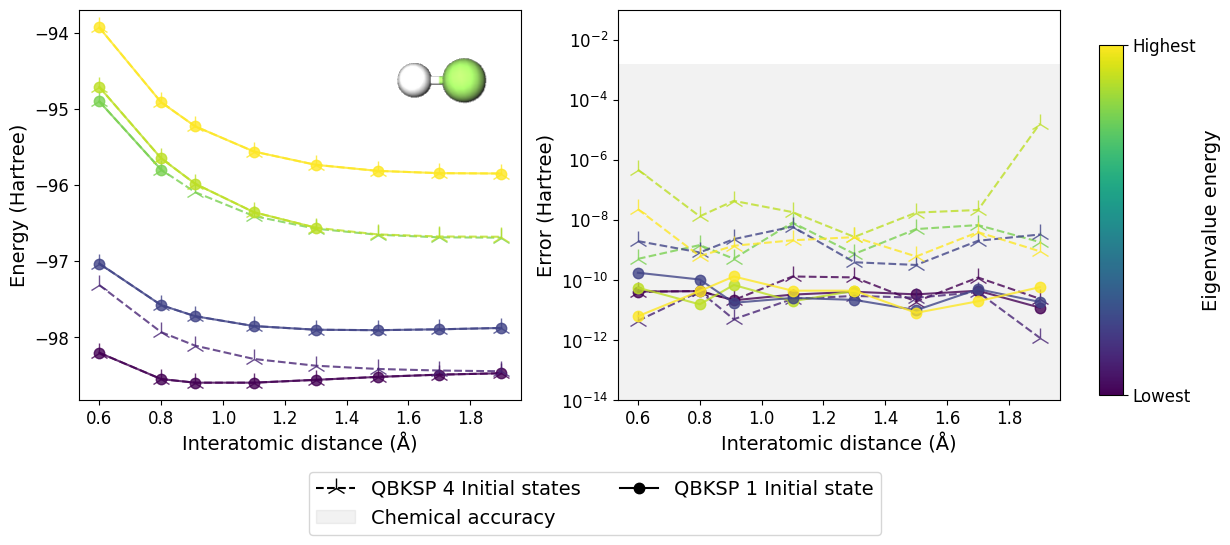

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Configuration
label_fontsize = 14
tick_fontsize = 12
line_styles =  {'QBKSP 1 Initial state': '-', 'QBKSP 4 Initial states': '--'}
markers = {'QBKSP 1 Initial state': '.', 'QBKSP 4 Initial states': '2'}
gray_patch = [mpatches.Patch(color='gray', alpha=0.1, label='Chemical accuracy')]
markers_handle = [
    mlines.Line2D([], [], color='black', marker='.', linestyle='-', label='QBKSP 1 Initial state',markersize=15)
   
]
line_handles = [
    mlines.Line2D([], [], color='black', marker='2', linestyle='--', label='QBKSP 4 Initial states',markersize=15)

] + gray_patch + markers_handle

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=10)

for i in range(3):
    # Define colors
    color_main = cmap(norm(i))
    color_offset = cmap(norm(i + 8))

    for j, (color, idx_offset) in enumerate([(color_main, 0), (color_offset, 8)]):
        idx = i + idx_offset
        x_vals = list_dist[1:len(listt_vals4[idx])]
        x_vals1 = list_dist[1:len(listt_vals1[idx])]
        y_exact = list_teo[idx][1:len(listt_vals4[idx])]
        y_exact1 = list_teo[idx][1:len(listt_vals1[idx])]
        y_qbksp = listt_vals4[idx][1:]
        y_qbksp1 = listt_vals1[idx][1:]

       # axs[0].plot(list_dist[1:], list_teo[idx][1:], '--', color=color, alpha=0.8)
        axs[0].plot(x_vals1, y_exact1, color=color, alpha=0.8, marker=markers['QBKSP 1 Initial state'], markersize=15, linestyle=line_styles['QBKSP 1 Initial state'],
                    label='Exact' if i == 0 and j == 0 else None)
        axs[0].plot(x_vals, y_qbksp, color=color, alpha=0.8, marker=markers['QBKSP 4 Initial states'], markersize=15, linestyle=line_styles['QBKSP 4 Initial states'],
                    label='Exact' if i == 0 and j == 0 else None)
        axs[1].plot(x_vals1, np.abs(np.array(y_exact1) - np.array(y_qbksp1)), line_styles['QBKSP 1 Initial state']
                    , color=color, alpha=0.8, marker=markers['QBKSP 1 Initial state'],markersize=15)
        axs[1].plot(x_vals, np.abs(np.array(y_exact) - np.array(y_qbksp)), line_styles['QBKSP 4 Initial states']
                    , color=color, alpha=0.8,marker=markers['QBKSP 4 Initial states'],markersize=15)
        
       
# Axis labels and styles
axs[0].set_ylabel('Energy (Hartree)', fontsize=label_fontsize)
axs[0].set_xlabel('Interatomic distance (Å)', fontsize=label_fontsize)
axs[0].tick_params(labelsize=tick_fontsize)

axs[1].set_ylabel('Error (Hartree)', fontsize=label_fontsize)
axs[1].set_xlabel('Interatomic distance (Å)', fontsize=label_fontsize)
axs[1].set_yscale('log')
axs[1].set_ylim(1e-14, 1e-1)
axs[1].tick_params(labelsize=tick_fontsize)
axs[1].axhspan(0, 1.6e-3, facecolor='gray', alpha=0.1)

# Colorbar
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.7])
cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='vertical', ticks=[0, 10])
cb.ax.set_yticklabels(['Lowest', 'Highest'])
cb.set_label('Eigenvalue energy', fontsize=label_fontsize)
cb.ax.tick_params(labelsize=tick_fontsize)

# Legend and layout
fig.legend(handles=line_handles, loc='lower center', fontsize=label_fontsize,
           bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.tight_layout(rect=[0, 0.05, 0.9, 1])
# -------- IMAGE IN TOP-RIGHT CORNER --------
img_path = f'HF.png'  # Replace with your actual PNG filename
img = mpimg.imread(img_path)
imagebox = OffsetImage(img, zoom=0.7)  # Adjust zoom as needed

# Coordinates in axis fraction (1,1) = top-right corner of the Axes
ab = AnnotationBbox(imagebox, (0.95, 0.95), xycoords='axes fraction',
                    box_alignment=(1, 1), frameon=False)
axs[0].add_artist(ab)  # Add image to the top-right corner of the first subplot
# Save figure
plt.savefig(f'{Data_path}/figure4.pdf',format='pdf', bbox_inches='tight')
plt.show()
